We’ll start by doing all necessary imports, and we’ll let our Jupyter Notebook know that it should display graphs and images in the notebook itself.

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile

The files we're about to use may take five minutes or more to download, so if you're following along by running the program in the corresponding notebook, feel free to start running the next few cells. In the meantime, let’s explore textual entailment in further detail.

In [2]:
glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"

snli_zip_file = "snli_1.0.zip"
snli_dev_file = "snli_1.0_dev.txt"
snli_full_dataset_file = "snli_1.0_train.txt"

In [3]:
from six.moves.urllib.request import urlretrieve
    
#large file - 862 MB
if (not os.path.isfile(glove_zip_file) and
    not os.path.isfile(glove_vectors_file)):
    urlretrieve ("http://nlp.stanford.edu/data/glove.6B.zip", 
                 glove_zip_file)

#medium-sized file - 94.6 MB
if (not os.path.isfile(snli_zip_file) and
    not os.path.isfile(snli_dev_file)):
    urlretrieve ("https://nlp.stanford.edu/projects/snli/snli_1.0.zip", 
                 snli_zip_file)

In [4]:
def unzip_single_file(zip_file_name, output_file_name):
    """
        If the outFile is already created, don't recreate
        If the outFile does not exist, create it from the zipFile
    """
    if not os.path.isfile(output_file_name):
        with open(output_file_name, 'wb') as out_file:
            with zipfile.ZipFile(zip_file_name) as zipped:
                for info in zipped.infolist():
                    if output_file_name in info.filename:
                        with zipped.open(info) as requested_file:
                            out_file.write(requested_file.read())
                            return

unzip_single_file(glove_zip_file, glove_vectors_file)
unzip_single_file(snli_zip_file, snli_dev_file)
# unzip_single_file(snli_zip_file, snli_full_dataset_file)

---

Now that we have our GloVe vectors downloaded, we can load them into memory, deserializing the space separated format into a Python dictionary:

In [5]:
glove_wordmap = {}
with open(glove_vectors_file, "r",encoding='utf-8') as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")

---

Once we have our words, we need our input to contain entire sentences and process it through a neural network. Let's start with making the sequence:

In [6]:
def sentence2sequence(sentence):
    """
     
    - Turns an input sentence into an (n,d) matrix, 
        where n is the number of tokens in the sentence
        and d is the number of dimensions each word vector has.
    
      Tensorflow doesn't need to be used here, as simply
      turning the sentence into a sequence based off our 
      mapping does not need the computational power that
      Tensorflow provides. Normal Python suffices for this task.
    """
    tokens = sentence.lower().split(" ")
    rows = []
    words = []
    #Greedy search for tokens
    for token in tokens:
        i = len(token)
        while len(token) > 0 and i > 0:
            word = token[:i]
            if word in glove_wordmap:
                rows.append(glove_wordmap[word])
                words.append(word)
                token = token[i:]
                i = len(token)
            else:
                i = i-1
    return rows, words

To better visualize the word vectorization process, and to see what the computer sees when it looks at a sentence, we can represent the vectors as images. Each row represents a single word, and the columns represent individual dimensions of the vectorized word.  The vectorizations are trained in terms of relationships to other words, and so what the representations actually mean is ambiguous.  The computer can understand this vector language, and that’s the most important part to us. Generally speaking, two vectors that contain similar colors in the same positions represent words that are similar in meaning.


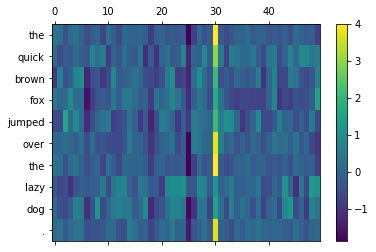

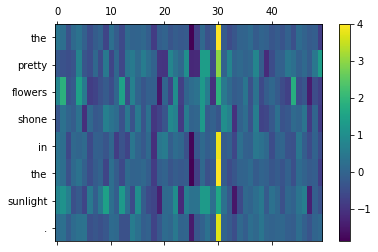

In [8]:
def visualize(sentence):
    rows, words = sentence2sequence(sentence)
    mat = np.vstack(rows)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    shown = ax.matshow(mat, aspect="auto")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.colorbar(shown)
    
    ax.set_yticklabels([""]+words)
    plt.show()
    
visualize("The quick brown fox jumped over the lazy dog.")
visualize("The pretty flowers shone in the sunlight.")

-----
Recurrent Neural Networks (also known as RNNs) are a sequence-learning tool for neural networks. This type of neural network has only one layer’s worth of hidden inputs, which is re-used for each input from the sequence, along with a “memory” that’s passed ahead to the next input’s calculations. These are calculated using matrix multiplication where the matrix indices are trained weights, just like they are in a fully-connected layer. 

The same calculations are repeated for each input in the sequence, meaning that a single “layer” of a recurrent neural network can be unrolled into many layers. In fact, there will be as many layers as there are inputs in the sequence. This allows the network to process a very complex sentence. TensorFlow includes its own implementation of a vanilla RNN cell, BasicRNNCell, which can be added to your TensorFlow graph as follows:

In [9]:
rnn_size = 64
rnn = tf.contrib.rnn.BasicRNNCell(rnn_size)

----

# Defining the constants for our network

Since we aren’t going to use a vanilla RNN layer in our network, let's clear out the graph and add an LSTM layer, which TensorFlow also includes by default. Since this is going to be the first part of our actual network, let's also define all the constants we'll need for the network, which we'll talk about as they come up:

In [60]:
#Constants setup
max_hypothesis_length, max_evidence_length = 30,30
batch_size, vector_size, hidden_size = 128, 50, 64

lstm_size = hidden_size

weight_decay = 0.0001

learning_rate = 1

input_p, output_p = 0.5, 0.5

training_iterations_count = 1000000

display_step = 10

def score_setup(row):
    convert_dict = {
      'entailment': 0,
      'neutral': 1,
      'contradiction': 2
    }
    score = np.zeros((3,))
    for x in range(1,6):
        tag = row["label"+str(x)]
        if tag in convert_dict: score[convert_dict[tag]] += 1
    return score / (1.0*np.sum(score))

def fit_to_size(matrix, shape):
    res = np.zeros(shape)
    slices = [slice(0,min(dim,shape[e])) for e, dim in enumerate(matrix.shape)]
    res[slices] = matrix[slices]
    return res


In [61]:
def split_data_into_scores():
    import csv
    with open("snli_1.0_dev.txt","r",encoding='utf-8') as data:
        train = csv.DictReader(data, delimiter='\t')
        evi_sentences = []
        hyp_sentences = []
        labels = []
        scores = []
        for row in train:
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence1"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence2"].lower())[0]))
            labels.append(row["gold_label"])
            scores.append(score_setup(row))
        
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                          for x in evi_sentences])
                                 
        return (hyp_sentences, evi_sentences), labels, np.array(scores)
    
data_feature_list, correct_values, correct_scores = split_data_into_scores()

l_h, l_e = max_hypothesis_length, max_evidence_length
N, D, H = batch_size, vector_size, hidden_size
l_seq = l_h + l_e


We'll also reset the graph to not include the RNN cell we added earlier, since we won't be using that for this network:



In [62]:
tf.reset_default_graph()

With both those out of the way, we can define our LSTM using TensorFlow as follows:

In [63]:
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

The loss of certain pieces of crucial memory means that complicated relationships required for first order logic have a harder time forming with dropout, and so for our LSTM layer we’ll skip using dropout on internal gates, instead using it on everything else. Thankfully, this is the default implementation of Tensorflow’s DropoutWrapper for recurrent layers:


In [64]:
lstm_drop =  tf.contrib.rnn.DropoutWrapper(lstm, input_p, output_p)

----

With all the explanations out of the way, we can finish up our model. The first step is tokenizing and using our GloVe dictionary to turn the two input sentences into a single sequence of vectors. Since we can’t effectively use dropout on information that gets passed within an LSTM, we’ll use dropout on features from words, and on final output instead -- effectively using dropout on the first and last layers from the unrolled LSTM network portions. 

The final output from the LSTMs will be passed into a set of fully connected layers, and then from that we’ll get a single real-valued score that indicates how strong each of the kinds of entailment are, which we use to select our final result and our confidence in that result.

In [65]:
# N: The number of elements in each of our batches, 
#   which we use to train subsets of data for efficiency's sake.
# l_h: The maximum length of a hypothesis, or the second sentence.  This is
#   used because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# l_e: The maximum length of evidence, the first sentence.  This is used
#   because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# D: The size of our used GloVe or other vectors.
hyp = tf.placeholder(tf.float32, [N, l_h, D], 'hypothesis')
evi = tf.placeholder(tf.float32, [N, l_e, D], 'evidence')
y = tf.placeholder(tf.float32, [N, 3], 'label')
# hyp: Where the hypotheses will be stored during training.
# evi: Where the evidences will be stored during training.
# y: Where correct scores will be stored during training.

# lstm_size: the size of the gates in the LSTM, 
#    as in the first LSTM layer's initialization.
lstm_back = tf.contrib.rnn.BasicLSTMCell(lstm_size)
# lstm_back:  The LSTM used for looking backwards 
#   through the sentences, similar to lstm.

# input_p: the probability that inputs to the LSTM will be retained at each
#   iteration of dropout.
# output_p: the probability that outputs from the LSTM will be retained at 
#   each iteration of dropout.
lstm_drop_back = tf.contrib.rnn.DropoutWrapper(lstm_back, input_p, output_p)
# lstm_drop_back:  A dropout wrapper for lstm_back, like lstm_drop.


fc_initializer = tf.random_normal_initializer(stddev=0.1) 
# fc_initializer: initial values for the fully connected layer's weights.
# hidden_size: the size of the outputs from each lstm layer.  
#   Multiplied by 2 to account for the two LSTMs.
fc_weight = tf.get_variable('fc_weight', [2*hidden_size, 3], 
                            initializer = fc_initializer)
# fc_weight: Storage for the fully connected layer's weights.
fc_bias = tf.get_variable('bias', [3])
# fc_bias: Storage for the fully connected layer's bias.

# tf.GraphKeys.REGULARIZATION_LOSSES:  A key to a collection in the graph
#   designated for losses due to regularization.
#   In this case, this portion of loss is regularization on the weights
#   for the fully connected layer.
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(fc_weight)) 

x = tf.concat([hyp, evi], 1) # N, (Lh+Le), d
# Permuting batch_size and n_steps
x = tf.transpose(x, [1, 0, 2]) # (Le+Lh), N, d
# Reshaping to (n_steps*batch_size, n_input)
x = tf.reshape(x, [-1, vector_size]) # (Le+Lh)*N, d
# Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
x = tf.split(x, l_seq,)

# x: the inputs to the bidirectional_rnn


# tf.contrib.rnn.static_bidirectional_rnn: Runs the input through
#   two recurrent networks, one that runs the inputs forward and one
#   that runs the inputs in reversed order, combining the outputs.
rnn_outputs, _, _ = tf.contrib.rnn.static_bidirectional_rnn(lstm, lstm_back,
                                                            x, dtype=tf.float32)
# rnn_outputs: the list of LSTM outputs, as a list. 
#   What we want is the latest output, rnn_outputs[-1]

classification_scores = tf.matmul(rnn_outputs[-1], fc_weight) + fc_bias
# The scores are relative certainties for how likely the output matches
#   a certain entailment: 
#     0: Positive entailment
#     1: Neutral entailment
#     2: Negative entailment

In order to test the accuracy and begin to add in optimization constraints, we need to show TensorFlow how to calculate the accuracy, or -- the percentage of correctly predicted labels.

We also need to determine a loss, to show how poorly the network is doing. Since we have both classification scores and optimal scores, the choice here is using a variation on softmax loss from Tensorflow: tf.nn.softmax_cross_entropy_with_logits. We add in regularization losses to help with overfitting, and then prepare an optimizer to learn how to reduce the loss.

In [66]:
with tf.variable_scope('Accuracy'):
    predicts = tf.cast(tf.argmax(classification_scores, 1), 'int32')
    y_label = tf.cast(tf.argmax(y, 1), 'int32')
    corrects = tf.equal(predicts, y_label)
    num_corrects = tf.reduce_sum(tf.cast(corrects, tf.float32))
    accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))

with tf.variable_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        logits = classification_scores, labels = y)
    loss = tf.reduce_mean(cross_entropy)
    total_loss = loss + weight_decay * tf.add_n(
        tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

optimizer = tf.train.GradientDescentOptimizer(learning_rate)

opt_op = optimizer.minimize(total_loss)

Finally, we can train the network! If you installed TQDM, you can use it to keep track of progress as the network trains.


In [67]:
# Initialize variables
init = tf.global_variables_initializer()

# Use TQDM if installed
tqdm_installed = False
try:
    from tqdm import tqdm
    tqdm_installed = True
except:
    pass

# Launch the Tensorflow session
sess = tf.Session()
sess.run(init)

# training_iterations_count: The number of data pieces to train on in total
# batch_size: The number of data pieces per batch
training_iterations = range(0,training_iterations_count,batch_size)
if tqdm_installed:
    # Add a progress bar if TQDM is installed
    training_iterations = tqdm(training_iterations)

for i in training_iterations:

    # Select indices for a random data subset
    batch = np.random.randint(data_feature_list[0].shape[0], size=batch_size)
    
    # Use the selected subset indices to initialize the graph's 
    #   placeholder values
    hyps, evis, ys = (data_feature_list[0][batch,:],
                      data_feature_list[1][batch,:],
                      correct_scores[batch])
    
    # Run the optimization with these initialized values
    sess.run([opt_op], feed_dict={hyp: hyps, evi: evis, y: ys})
    # display_step: how often the accuracy and loss should 
    #   be tested and displayed.
    if (i/batch_size) % display_step == 0:
        # Calculate batch accuracy
        acc = sess.run(accuracy, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Calculate batch loss
        tmp_loss = sess.run(loss, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Display results
        print("Iter " + str(i/batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(tmp_loss) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))

  0%|                                                                                         | 0/7813 [00:00<?, ?it/s]

Iter 0.0, Minibatch Loss= 1.093484, Training Accuracy= 0.37500


  0%|                                                                                 | 8/7813 [00:00<22:19,  5.83it/s]

Iter 10.0, Minibatch Loss= 1.096952, Training Accuracy= 0.36719


  0%|▏                                                                               | 19/7813 [00:01<09:40, 13.43it/s]

Iter 20.0, Minibatch Loss= 1.090341, Training Accuracy= 0.35938


  0%|▎                                                                               | 30/7813 [00:02<07:36, 17.05it/s]

Iter 30.0, Minibatch Loss= 1.093341, Training Accuracy= 0.37500


  1%|▍                                                                               | 40/7813 [00:02<07:27, 17.38it/s]

Iter 40.0, Minibatch Loss= 1.081756, Training Accuracy= 0.42188


  1%|▌                                                                               | 50/7813 [00:03<07:24, 17.46it/s]

Iter 50.0, Minibatch Loss= 1.085486, Training Accuracy= 0.42969


  1%|▌                                                                               | 60/7813 [00:03<06:55, 18.64it/s]

Iter 60.0, Minibatch Loss= 1.086378, Training Accuracy= 0.44531


  1%|▋                                                                               | 70/7813 [00:04<07:54, 16.33it/s]

Iter 70.0, Minibatch Loss= 1.078664, Training Accuracy= 0.40625


  1%|▊                                                                               | 80/7813 [00:04<07:05, 18.15it/s]

Iter 80.0, Minibatch Loss= 1.089875, Training Accuracy= 0.34375


  1%|▉                                                                               | 90/7813 [00:05<06:51, 18.79it/s]

Iter 90.0, Minibatch Loss= 1.082460, Training Accuracy= 0.42969


  1%|█                                                                              | 100/7813 [00:06<06:47, 18.91it/s]

Iter 100.0, Minibatch Loss= 1.075115, Training Accuracy= 0.42969


  1%|█                                                                              | 109/7813 [00:06<06:48, 18.86it/s]

Iter 110.0, Minibatch Loss= 1.069343, Training Accuracy= 0.44531


  2%|█▏                                                                             | 119/7813 [00:07<06:49, 18.81it/s]

Iter 120.0, Minibatch Loss= 1.076965, Training Accuracy= 0.38281


  2%|█▎                                                                             | 129/7813 [00:07<06:49, 18.76it/s]

Iter 130.0, Minibatch Loss= 1.073711, Training Accuracy= 0.42188


  2%|█▍                                                                             | 139/7813 [00:08<07:02, 18.18it/s]

Iter 140.0, Minibatch Loss= 1.088130, Training Accuracy= 0.40625


  2%|█▌                                                                             | 149/7813 [00:08<07:34, 16.88it/s]

Iter 150.0, Minibatch Loss= 1.044434, Training Accuracy= 0.42969


  2%|█▌                                                                             | 159/7813 [00:09<07:09, 17.81it/s]

Iter 160.0, Minibatch Loss= 1.087569, Training Accuracy= 0.40625


  2%|█▋                                                                             | 169/7813 [00:10<07:53, 16.16it/s]

Iter 170.0, Minibatch Loss= 1.094261, Training Accuracy= 0.40625


  2%|█▊                                                                             | 179/7813 [00:10<06:58, 18.22it/s]

Iter 180.0, Minibatch Loss= 1.047291, Training Accuracy= 0.48438


  2%|█▉                                                                             | 189/7813 [00:11<06:47, 18.72it/s]

Iter 190.0, Minibatch Loss= 1.080197, Training Accuracy= 0.42188


  3%|██                                                                             | 199/7813 [00:11<06:46, 18.74it/s]

Iter 200.0, Minibatch Loss= 1.079738, Training Accuracy= 0.44531


  3%|██                                                                             | 209/7813 [00:12<06:47, 18.64it/s]

Iter 210.0, Minibatch Loss= 1.037160, Training Accuracy= 0.50000


  3%|██▏                                                                            | 219/7813 [00:12<06:47, 18.64it/s]

Iter 220.0, Minibatch Loss= 1.087882, Training Accuracy= 0.38281


  3%|██▎                                                                            | 229/7813 [00:13<06:46, 18.65it/s]

Iter 230.0, Minibatch Loss= 1.035287, Training Accuracy= 0.49219


  3%|██▍                                                                            | 239/7813 [00:14<07:22, 17.12it/s]

Iter 240.0, Minibatch Loss= 1.089934, Training Accuracy= 0.42188


  3%|██▌                                                                            | 249/7813 [00:14<07:09, 17.61it/s]

Iter 250.0, Minibatch Loss= 1.082147, Training Accuracy= 0.39844


  3%|██▌                                                                            | 259/7813 [00:15<07:20, 17.17it/s]

Iter 260.0, Minibatch Loss= 1.093796, Training Accuracy= 0.38281


  3%|██▋                                                                            | 269/7813 [00:15<07:29, 16.80it/s]

Iter 270.0, Minibatch Loss= 1.098109, Training Accuracy= 0.35156


  4%|██▊                                                                            | 279/7813 [00:16<06:54, 18.19it/s]

Iter 280.0, Minibatch Loss= 1.063899, Training Accuracy= 0.53906


  4%|██▉                                                                            | 289/7813 [00:17<06:48, 18.43it/s]

Iter 290.0, Minibatch Loss= 1.063323, Training Accuracy= 0.43750


  4%|███                                                                            | 299/7813 [00:17<06:53, 18.18it/s]

Iter 300.0, Minibatch Loss= 1.025040, Training Accuracy= 0.48438


  4%|███                                                                            | 309/7813 [00:18<07:26, 16.82it/s]

Iter 310.0, Minibatch Loss= 1.069454, Training Accuracy= 0.46094


  4%|███▏                                                                           | 319/7813 [00:18<07:22, 16.95it/s]

Iter 320.0, Minibatch Loss= 1.035358, Training Accuracy= 0.50000


  4%|███▎                                                                           | 329/7813 [00:19<06:56, 17.95it/s]

Iter 330.0, Minibatch Loss= 1.053026, Training Accuracy= 0.49219


  4%|███▍                                                                           | 339/7813 [00:20<07:36, 16.36it/s]

Iter 340.0, Minibatch Loss= 1.057666, Training Accuracy= 0.42188


  4%|███▌                                                                           | 349/7813 [00:20<07:05, 17.54it/s]

Iter 350.0, Minibatch Loss= 1.037510, Training Accuracy= 0.53906


  5%|███▋                                                                           | 359/7813 [00:21<08:07, 15.29it/s]

Iter 360.0, Minibatch Loss= 1.090156, Training Accuracy= 0.36719


  5%|███▋                                                                           | 369/7813 [00:21<07:03, 17.59it/s]

Iter 370.0, Minibatch Loss= 1.053469, Training Accuracy= 0.46094


  5%|███▊                                                                           | 379/7813 [00:22<06:51, 18.09it/s]

Iter 380.0, Minibatch Loss= 1.091388, Training Accuracy= 0.41406


  5%|███▉                                                                           | 389/7813 [00:23<06:49, 18.11it/s]

Iter 390.0, Minibatch Loss= 1.077888, Training Accuracy= 0.34375


  5%|████                                                                           | 399/7813 [00:23<06:48, 18.15it/s]

Iter 400.0, Minibatch Loss= 1.040813, Training Accuracy= 0.47656


  5%|████▏                                                                          | 409/7813 [00:24<06:53, 17.91it/s]

Iter 410.0, Minibatch Loss= 1.078690, Training Accuracy= 0.44531


  5%|████▏                                                                          | 419/7813 [00:24<06:45, 18.22it/s]

Iter 420.0, Minibatch Loss= 1.030397, Training Accuracy= 0.49219


  5%|████▎                                                                          | 429/7813 [00:25<07:14, 16.99it/s]

Iter 430.0, Minibatch Loss= 1.042792, Training Accuracy= 0.49219


  6%|████▍                                                                          | 439/7813 [00:26<06:53, 17.83it/s]

Iter 440.0, Minibatch Loss= 1.054574, Training Accuracy= 0.44531


  6%|████▌                                                                          | 449/7813 [00:26<07:23, 16.59it/s]

Iter 450.0, Minibatch Loss= 1.034264, Training Accuracy= 0.55469


  6%|████▋                                                                          | 459/7813 [00:27<07:31, 16.30it/s]

Iter 460.0, Minibatch Loss= 1.048827, Training Accuracy= 0.47656


  6%|████▋                                                                          | 469/7813 [00:27<06:59, 17.53it/s]

Iter 470.0, Minibatch Loss= 1.037822, Training Accuracy= 0.48438


  6%|████▊                                                                          | 479/7813 [00:28<07:35, 16.11it/s]

Iter 480.0, Minibatch Loss= 1.062921, Training Accuracy= 0.42188


  6%|████▉                                                                          | 489/7813 [00:29<07:04, 17.26it/s]

Iter 490.0, Minibatch Loss= 1.071262, Training Accuracy= 0.42969


  6%|█████                                                                          | 499/7813 [00:29<06:49, 17.86it/s]

Iter 500.0, Minibatch Loss= 1.037575, Training Accuracy= 0.48438


  7%|█████▏                                                                         | 509/7813 [00:30<06:50, 17.79it/s]

Iter 510.0, Minibatch Loss= 1.042583, Training Accuracy= 0.44531


  7%|█████▏                                                                         | 519/7813 [00:30<07:29, 16.24it/s]

Iter 520.0, Minibatch Loss= 1.057128, Training Accuracy= 0.47656


  7%|█████▎                                                                         | 529/7813 [00:31<07:13, 16.79it/s]

Iter 530.0, Minibatch Loss= 1.070781, Training Accuracy= 0.42969


  7%|█████▍                                                                         | 539/7813 [00:32<07:50, 15.47it/s]

Iter 540.0, Minibatch Loss= 1.038529, Training Accuracy= 0.46875


  7%|█████▌                                                                         | 549/7813 [00:32<08:03, 15.02it/s]

Iter 550.0, Minibatch Loss= 1.046417, Training Accuracy= 0.49219


  7%|█████▋                                                                         | 559/7813 [00:33<06:58, 17.35it/s]

Iter 560.0, Minibatch Loss= 1.076691, Training Accuracy= 0.44531


  7%|█████▊                                                                         | 569/7813 [00:34<07:23, 16.34it/s]

Iter 570.0, Minibatch Loss= 1.042602, Training Accuracy= 0.50781


  7%|█████▊                                                                         | 579/7813 [00:34<07:23, 16.31it/s]

Iter 580.0, Minibatch Loss= 1.091402, Training Accuracy= 0.37500


  8%|█████▉                                                                         | 589/7813 [00:35<06:49, 17.66it/s]

Iter 590.0, Minibatch Loss= 1.040096, Training Accuracy= 0.45312


  8%|██████                                                                         | 599/7813 [00:35<06:44, 17.85it/s]

Iter 600.0, Minibatch Loss= 1.048873, Training Accuracy= 0.44531


  8%|██████▏                                                                        | 609/7813 [00:36<07:09, 16.76it/s]

Iter 610.0, Minibatch Loss= 1.028488, Training Accuracy= 0.48438


  8%|██████▎                                                                        | 619/7813 [00:37<06:50, 17.53it/s]

Iter 620.0, Minibatch Loss= 1.036623, Training Accuracy= 0.53125


  8%|██████▎                                                                        | 629/7813 [00:37<06:44, 17.75it/s]

Iter 630.0, Minibatch Loss= 1.006715, Training Accuracy= 0.53906


  8%|██████▍                                                                        | 639/7813 [00:38<07:48, 15.32it/s]

Iter 640.0, Minibatch Loss= 1.061676, Training Accuracy= 0.46094


  8%|██████▌                                                                        | 649/7813 [00:39<06:53, 17.31it/s]

Iter 650.0, Minibatch Loss= 1.039653, Training Accuracy= 0.51562


  8%|██████▋                                                                        | 659/7813 [00:39<06:42, 17.79it/s]

Iter 660.0, Minibatch Loss= 1.022319, Training Accuracy= 0.46875


  9%|██████▊                                                                        | 669/7813 [00:40<06:39, 17.89it/s]

Iter 670.0, Minibatch Loss= 1.063604, Training Accuracy= 0.50000


  9%|██████▊                                                                        | 679/7813 [00:40<06:36, 17.98it/s]

Iter 680.0, Minibatch Loss= 1.029361, Training Accuracy= 0.52344


  9%|██████▉                                                                        | 689/7813 [00:41<06:38, 17.89it/s]

Iter 690.0, Minibatch Loss= 1.027555, Training Accuracy= 0.51562


  9%|███████                                                                        | 699/7813 [00:41<07:02, 16.84it/s]

Iter 700.0, Minibatch Loss= 0.998180, Training Accuracy= 0.53906


  9%|███████▏                                                                       | 709/7813 [00:42<06:50, 17.30it/s]

Iter 710.0, Minibatch Loss= 1.064004, Training Accuracy= 0.37500


  9%|███████▎                                                                       | 719/7813 [00:43<06:47, 17.42it/s]

Iter 720.0, Minibatch Loss= 1.024520, Training Accuracy= 0.50000


  9%|███████▎                                                                       | 729/7813 [00:43<07:31, 15.70it/s]

Iter 730.0, Minibatch Loss= 1.051508, Training Accuracy= 0.51562


  9%|███████▍                                                                       | 739/7813 [00:44<07:11, 16.39it/s]

Iter 740.0, Minibatch Loss= 1.036152, Training Accuracy= 0.53906


 10%|███████▌                                                                       | 749/7813 [00:45<06:46, 17.37it/s]

Iter 750.0, Minibatch Loss= 1.010070, Training Accuracy= 0.52344


 10%|███████▋                                                                       | 759/7813 [00:45<06:37, 17.72it/s]

Iter 760.0, Minibatch Loss= 1.065301, Training Accuracy= 0.39062


 10%|███████▊                                                                       | 769/7813 [00:46<06:35, 17.82it/s]

Iter 770.0, Minibatch Loss= 1.067516, Training Accuracy= 0.46875


 10%|███████▉                                                                       | 779/7813 [00:46<06:37, 17.69it/s]

Iter 780.0, Minibatch Loss= 1.050396, Training Accuracy= 0.47656


 10%|███████▉                                                                       | 789/7813 [00:47<07:01, 16.68it/s]

Iter 790.0, Minibatch Loss= 1.026009, Training Accuracy= 0.50000


 10%|████████                                                                       | 799/7813 [00:48<06:52, 16.99it/s]

Iter 800.0, Minibatch Loss= 1.027093, Training Accuracy= 0.47656


 10%|████████▏                                                                      | 809/7813 [00:48<06:34, 17.75it/s]

Iter 810.0, Minibatch Loss= 1.024946, Training Accuracy= 0.52344


 10%|████████▎                                                                      | 819/7813 [00:49<06:54, 16.88it/s]

Iter 820.0, Minibatch Loss= 1.004096, Training Accuracy= 0.53125


 11%|████████▍                                                                      | 829/7813 [00:49<07:38, 15.23it/s]

Iter 830.0, Minibatch Loss= 1.047942, Training Accuracy= 0.44531


 11%|████████▍                                                                      | 839/7813 [00:50<07:12, 16.13it/s]

Iter 840.0, Minibatch Loss= 1.007930, Training Accuracy= 0.49219


 11%|████████▌                                                                      | 849/7813 [00:51<06:40, 17.38it/s]

Iter 850.0, Minibatch Loss= 1.029554, Training Accuracy= 0.53906


 11%|████████▋                                                                      | 859/7813 [00:51<06:32, 17.71it/s]

Iter 860.0, Minibatch Loss= 1.040540, Training Accuracy= 0.54688


 11%|████████▊                                                                      | 869/7813 [00:52<06:29, 17.81it/s]

Iter 870.0, Minibatch Loss= 1.051020, Training Accuracy= 0.50781


 11%|████████▉                                                                      | 879/7813 [00:53<06:43, 17.17it/s]

Iter 880.0, Minibatch Loss= 1.036294, Training Accuracy= 0.48438


 11%|████████▉                                                                      | 889/7813 [00:53<06:43, 17.18it/s]

Iter 890.0, Minibatch Loss= 1.057949, Training Accuracy= 0.48438


 12%|█████████                                                                      | 899/7813 [00:54<06:34, 17.51it/s]

Iter 900.0, Minibatch Loss= 1.008056, Training Accuracy= 0.56250


 12%|█████████▏                                                                     | 909/7813 [00:54<06:32, 17.61it/s]

Iter 910.0, Minibatch Loss= 0.997678, Training Accuracy= 0.52344


 12%|█████████▎                                                                     | 919/7813 [00:55<07:31, 15.27it/s]

Iter 920.0, Minibatch Loss= 1.073904, Training Accuracy= 0.39062


 12%|█████████▍                                                                     | 929/7813 [00:56<06:37, 17.31it/s]

Iter 930.0, Minibatch Loss= 1.016189, Training Accuracy= 0.50781


 12%|█████████▍                                                                     | 939/7813 [00:56<06:25, 17.84it/s]

Iter 940.0, Minibatch Loss= 0.996434, Training Accuracy= 0.48438


 12%|█████████▌                                                                     | 949/7813 [00:57<06:33, 17.43it/s]

Iter 950.0, Minibatch Loss= 0.997793, Training Accuracy= 0.53125


 12%|█████████▋                                                                     | 959/7813 [00:57<06:24, 17.81it/s]

Iter 960.0, Minibatch Loss= 0.998101, Training Accuracy= 0.47656


 12%|█████████▊                                                                     | 969/7813 [00:58<06:24, 17.80it/s]

Iter 970.0, Minibatch Loss= 0.980479, Training Accuracy= 0.57031


 13%|█████████▉                                                                     | 979/7813 [00:59<06:48, 16.73it/s]

Iter 980.0, Minibatch Loss= 0.987975, Training Accuracy= 0.54688


 13%|██████████                                                                     | 989/7813 [00:59<06:23, 17.79it/s]

Iter 990.0, Minibatch Loss= 1.039295, Training Accuracy= 0.55469


 13%|██████████                                                                     | 999/7813 [01:00<06:22, 17.84it/s]

Iter 1000.0, Minibatch Loss= 1.021290, Training Accuracy= 0.47656


 13%|██████████                                                                    | 1009/7813 [01:00<07:13, 15.71it/s]

Iter 1010.0, Minibatch Loss= 1.045302, Training Accuracy= 0.50781


 13%|██████████▏                                                                   | 1019/7813 [01:01<06:44, 16.81it/s]

Iter 1020.0, Minibatch Loss= 1.052278, Training Accuracy= 0.46094


 13%|██████████▎                                                                   | 1029/7813 [01:02<06:21, 17.77it/s]

Iter 1030.0, Minibatch Loss= 1.037656, Training Accuracy= 0.47656


 13%|██████████▎                                                                   | 1039/7813 [01:02<06:17, 17.92it/s]

Iter 1040.0, Minibatch Loss= 1.018944, Training Accuracy= 0.49219


 13%|██████████▍                                                                   | 1049/7813 [01:03<06:21, 17.72it/s]

Iter 1050.0, Minibatch Loss= 1.064765, Training Accuracy= 0.41406


 14%|██████████▌                                                                   | 1059/7813 [01:03<06:15, 17.97it/s]

Iter 1060.0, Minibatch Loss= 1.027849, Training Accuracy= 0.48438


 14%|██████████▋                                                                   | 1069/7813 [01:04<06:48, 16.50it/s]

Iter 1070.0, Minibatch Loss= 1.056563, Training Accuracy= 0.46094


 14%|██████████▊                                                                   | 1079/7813 [01:05<06:22, 17.60it/s]

Iter 1080.0, Minibatch Loss= 1.031244, Training Accuracy= 0.54688


 14%|██████████▊                                                                   | 1089/7813 [01:05<06:17, 17.83it/s]

Iter 1090.0, Minibatch Loss= 1.052951, Training Accuracy= 0.47656


 14%|██████████▉                                                                   | 1099/7813 [01:06<07:16, 15.38it/s]

Iter 1100.0, Minibatch Loss= 1.017895, Training Accuracy= 0.53125


 14%|███████████                                                                   | 1109/7813 [01:07<07:20, 15.23it/s]

Iter 1110.0, Minibatch Loss= 1.006782, Training Accuracy= 0.48438


 14%|███████████▏                                                                  | 1119/7813 [01:07<06:34, 16.99it/s]

Iter 1120.0, Minibatch Loss= 0.989100, Training Accuracy= 0.54688


 14%|███████████▎                                                                  | 1129/7813 [01:08<06:17, 17.69it/s]

Iter 1130.0, Minibatch Loss= 1.026649, Training Accuracy= 0.54688


 15%|███████████▎                                                                  | 1139/7813 [01:08<06:13, 17.86it/s]

Iter 1140.0, Minibatch Loss= 0.950502, Training Accuracy= 0.57812


 15%|███████████▍                                                                  | 1149/7813 [01:09<06:14, 17.78it/s]

Iter 1150.0, Minibatch Loss= 1.028563, Training Accuracy= 0.47656


 15%|███████████▌                                                                  | 1159/7813 [01:10<06:42, 16.54it/s]

Iter 1160.0, Minibatch Loss= 0.942986, Training Accuracy= 0.62500


 15%|███████████▋                                                                  | 1169/7813 [01:10<06:18, 17.58it/s]

Iter 1170.0, Minibatch Loss= 0.996713, Training Accuracy= 0.53125


 15%|███████████▊                                                                  | 1179/7813 [01:11<06:11, 17.84it/s]

Iter 1180.0, Minibatch Loss= 0.986796, Training Accuracy= 0.50781


 15%|███████████▊                                                                  | 1189/7813 [01:11<06:12, 17.79it/s]

Iter 1190.0, Minibatch Loss= 1.038378, Training Accuracy= 0.48438


 15%|███████████▉                                                                  | 1199/7813 [01:12<07:10, 15.36it/s]

Iter 1200.0, Minibatch Loss= 0.989861, Training Accuracy= 0.56250


 15%|████████████                                                                  | 1209/7813 [01:13<06:24, 17.18it/s]

Iter 1210.0, Minibatch Loss= 1.014259, Training Accuracy= 0.49219


 16%|████████████▏                                                                 | 1219/7813 [01:13<06:09, 17.85it/s]

Iter 1220.0, Minibatch Loss= 0.983094, Training Accuracy= 0.62500


 16%|████████████▎                                                                 | 1229/7813 [01:14<06:12, 17.67it/s]

Iter 1230.0, Minibatch Loss= 1.001114, Training Accuracy= 0.53125


 16%|████████████▎                                                                 | 1239/7813 [01:14<06:08, 17.85it/s]

Iter 1240.0, Minibatch Loss= 1.000424, Training Accuracy= 0.53125


 16%|████████████▍                                                                 | 1249/7813 [01:15<06:32, 16.71it/s]

Iter 1250.0, Minibatch Loss= 1.033644, Training Accuracy= 0.49219


 16%|████████████▌                                                                 | 1259/7813 [01:16<06:15, 17.46it/s]

Iter 1260.0, Minibatch Loss= 1.051448, Training Accuracy= 0.47656


 16%|████████████▋                                                                 | 1269/7813 [01:16<06:07, 17.82it/s]

Iter 1270.0, Minibatch Loss= 1.024975, Training Accuracy= 0.50000


 16%|████████████▊                                                                 | 1279/7813 [01:17<06:15, 17.39it/s]

Iter 1280.0, Minibatch Loss= 0.972736, Training Accuracy= 0.59375


 16%|████████████▊                                                                 | 1289/7813 [01:17<06:48, 15.98it/s]

Iter 1290.0, Minibatch Loss= 1.019886, Training Accuracy= 0.53906


 17%|████████████▉                                                                 | 1299/7813 [01:18<06:27, 16.80it/s]

Iter 1300.0, Minibatch Loss= 1.039506, Training Accuracy= 0.51562


 17%|█████████████                                                                 | 1309/7813 [01:19<06:09, 17.62it/s]

Iter 1310.0, Minibatch Loss= 1.012922, Training Accuracy= 0.52344


 17%|█████████████▏                                                                | 1319/7813 [01:19<06:03, 17.88it/s]

Iter 1320.0, Minibatch Loss= 1.051130, Training Accuracy= 0.49219


 17%|█████████████▎                                                                | 1329/7813 [01:20<06:03, 17.84it/s]

Iter 1330.0, Minibatch Loss= 0.995308, Training Accuracy= 0.59375


 17%|█████████████▎                                                                | 1339/7813 [01:20<06:21, 16.99it/s]

Iter 1340.0, Minibatch Loss= 1.048997, Training Accuracy= 0.48438


 17%|█████████████▍                                                                | 1349/7813 [01:21<06:16, 17.16it/s]

Iter 1350.0, Minibatch Loss= 0.927615, Training Accuracy= 0.60156


 17%|█████████████▌                                                                | 1359/7813 [01:22<06:32, 16.42it/s]

Iter 1360.0, Minibatch Loss= 0.940981, Training Accuracy= 0.59375


 18%|█████████████▋                                                                | 1369/7813 [01:22<06:36, 16.27it/s]

Iter 1370.0, Minibatch Loss= 1.006951, Training Accuracy= 0.53125


 18%|█████████████▊                                                                | 1379/7813 [01:23<06:38, 16.13it/s]

Iter 1380.0, Minibatch Loss= 0.988180, Training Accuracy= 0.52344


 18%|█████████████▊                                                                | 1389/7813 [01:24<06:55, 15.45it/s]

Iter 1390.0, Minibatch Loss= 0.946038, Training Accuracy= 0.64844


 18%|█████████████▉                                                                | 1399/7813 [01:24<06:32, 16.36it/s]

Iter 1400.0, Minibatch Loss= 0.989173, Training Accuracy= 0.63281


 18%|██████████████                                                                | 1409/7813 [01:25<06:09, 17.35it/s]

Iter 1410.0, Minibatch Loss= 0.988179, Training Accuracy= 0.56250


 18%|██████████████▏                                                               | 1419/7813 [01:25<06:01, 17.67it/s]

Iter 1420.0, Minibatch Loss= 0.969113, Training Accuracy= 0.57812


 18%|██████████████▎                                                               | 1429/7813 [01:26<06:22, 16.67it/s]

Iter 1430.0, Minibatch Loss= 0.992581, Training Accuracy= 0.53906


 18%|██████████████▎                                                               | 1439/7813 [01:27<06:09, 17.27it/s]

Iter 1440.0, Minibatch Loss= 0.929871, Training Accuracy= 0.59375


 19%|██████████████▍                                                               | 1449/7813 [01:27<06:03, 17.51it/s]

Iter 1450.0, Minibatch Loss= 0.998441, Training Accuracy= 0.49219


 19%|██████████████▌                                                               | 1459/7813 [01:28<06:00, 17.64it/s]

Iter 1460.0, Minibatch Loss= 0.995211, Training Accuracy= 0.57031


 19%|██████████████▋                                                               | 1469/7813 [01:28<06:15, 16.88it/s]

Iter 1470.0, Minibatch Loss= 1.004878, Training Accuracy= 0.56250


 19%|██████████████▊                                                               | 1479/7813 [01:29<06:44, 15.66it/s]

Iter 1480.0, Minibatch Loss= 0.963845, Training Accuracy= 0.60156


 19%|██████████████▊                                                               | 1489/7813 [01:30<06:05, 17.30it/s]

Iter 1490.0, Minibatch Loss= 1.017079, Training Accuracy= 0.50781


 19%|██████████████▉                                                               | 1499/7813 [01:30<05:59, 17.56it/s]

Iter 1500.0, Minibatch Loss= 0.972662, Training Accuracy= 0.61719


 19%|███████████████                                                               | 1509/7813 [01:31<05:57, 17.64it/s]

Iter 1510.0, Minibatch Loss= 0.990170, Training Accuracy= 0.57031


 19%|███████████████▏                                                              | 1519/7813 [01:32<06:17, 16.68it/s]

Iter 1520.0, Minibatch Loss= 0.988331, Training Accuracy= 0.53906


 20%|███████████████▎                                                              | 1529/7813 [01:32<06:07, 17.10it/s]

Iter 1530.0, Minibatch Loss= 1.106213, Training Accuracy= 0.40625


 20%|███████████████▎                                                              | 1539/7813 [01:33<05:55, 17.64it/s]

Iter 1540.0, Minibatch Loss= 1.046882, Training Accuracy= 0.46875


 20%|███████████████▍                                                              | 1549/7813 [01:33<05:51, 17.82it/s]

Iter 1550.0, Minibatch Loss= 1.006867, Training Accuracy= 0.56250


 20%|███████████████▌                                                              | 1559/7813 [01:34<05:53, 17.71it/s]

Iter 1560.0, Minibatch Loss= 0.972377, Training Accuracy= 0.63281


 20%|███████████████▋                                                              | 1569/7813 [01:35<06:46, 15.36it/s]

Iter 1570.0, Minibatch Loss= 1.030502, Training Accuracy= 0.52344


 20%|███████████████▊                                                              | 1579/7813 [01:35<06:03, 17.13it/s]

Iter 1580.0, Minibatch Loss= 1.045879, Training Accuracy= 0.46875


 20%|███████████████▊                                                              | 1589/7813 [01:36<05:48, 17.84it/s]

Iter 1590.0, Minibatch Loss= 0.984407, Training Accuracy= 0.53906


 20%|███████████████▉                                                              | 1599/7813 [01:36<05:46, 17.94it/s]

Iter 1600.0, Minibatch Loss= 0.943250, Training Accuracy= 0.57812


 21%|████████████████                                                              | 1609/7813 [01:37<06:04, 17.02it/s]

Iter 1610.0, Minibatch Loss= 0.949824, Training Accuracy= 0.62500


 21%|████████████████▏                                                             | 1619/7813 [01:38<06:31, 15.80it/s]

Iter 1620.0, Minibatch Loss= 0.944070, Training Accuracy= 0.63281


 21%|████████████████▎                                                             | 1629/7813 [01:38<06:12, 16.62it/s]

Iter 1630.0, Minibatch Loss= 1.010454, Training Accuracy= 0.56250


 21%|████████████████▎                                                             | 1639/7813 [01:39<05:48, 17.72it/s]

Iter 1640.0, Minibatch Loss= 0.960247, Training Accuracy= 0.57031


 21%|████████████████▍                                                             | 1649/7813 [01:39<05:45, 17.85it/s]

Iter 1650.0, Minibatch Loss= 0.972050, Training Accuracy= 0.57812


 21%|████████████████▌                                                             | 1659/7813 [01:40<06:30, 15.76it/s]

Iter 1660.0, Minibatch Loss= 0.922931, Training Accuracy= 0.58594


 21%|████████████████▋                                                             | 1669/7813 [01:41<06:05, 16.79it/s]

Iter 1670.0, Minibatch Loss= 0.944300, Training Accuracy= 0.57031


 21%|████████████████▊                                                             | 1679/7813 [01:41<05:45, 17.77it/s]

Iter 1680.0, Minibatch Loss= 0.884875, Training Accuracy= 0.64062


 22%|████████████████▊                                                             | 1689/7813 [01:42<05:45, 17.74it/s]

Iter 1690.0, Minibatch Loss= 0.936310, Training Accuracy= 0.57812


 22%|████████████████▉                                                             | 1699/7813 [01:43<05:44, 17.76it/s]

Iter 1700.0, Minibatch Loss= 0.951247, Training Accuracy= 0.59375


 22%|█████████████████                                                             | 1709/7813 [01:43<06:04, 16.75it/s]

Iter 1710.0, Minibatch Loss= 0.968394, Training Accuracy= 0.59375


 22%|█████████████████▏                                                            | 1719/7813 [01:44<05:50, 17.40it/s]

Iter 1720.0, Minibatch Loss= 0.970695, Training Accuracy= 0.54688


 22%|█████████████████▎                                                            | 1729/7813 [01:44<05:39, 17.92it/s]

Iter 1730.0, Minibatch Loss= 0.971069, Training Accuracy= 0.57031


 22%|█████████████████▎                                                            | 1739/7813 [01:45<05:41, 17.81it/s]

Iter 1740.0, Minibatch Loss= 0.916879, Training Accuracy= 0.64062


 22%|█████████████████▍                                                            | 1749/7813 [01:46<06:00, 16.83it/s]

Iter 1750.0, Minibatch Loss= 0.934709, Training Accuracy= 0.57031


 23%|█████████████████▌                                                            | 1759/7813 [01:46<06:17, 16.05it/s]

Iter 1760.0, Minibatch Loss= 0.972314, Training Accuracy= 0.57031


 23%|█████████████████▋                                                            | 1769/7813 [01:47<05:54, 17.07it/s]

Iter 1770.0, Minibatch Loss= 0.971092, Training Accuracy= 0.55469


 23%|█████████████████▊                                                            | 1779/7813 [01:47<05:40, 17.75it/s]

Iter 1780.0, Minibatch Loss= 0.954957, Training Accuracy= 0.66406


 23%|█████████████████▊                                                            | 1789/7813 [01:48<05:39, 17.76it/s]

Iter 1790.0, Minibatch Loss= 0.888383, Training Accuracy= 0.64844


 23%|█████████████████▉                                                            | 1799/7813 [01:49<06:07, 16.37it/s]

Iter 1800.0, Minibatch Loss= 0.985939, Training Accuracy= 0.57812


 23%|██████████████████                                                            | 1809/7813 [01:49<05:40, 17.61it/s]

Iter 1810.0, Minibatch Loss= 0.982899, Training Accuracy= 0.58594


 23%|██████████████████▏                                                           | 1819/7813 [01:50<05:33, 17.95it/s]

Iter 1820.0, Minibatch Loss= 0.961988, Training Accuracy= 0.61719


 23%|██████████████████▎                                                           | 1829/7813 [01:50<05:33, 17.96it/s]

Iter 1830.0, Minibatch Loss= 0.961614, Training Accuracy= 0.62500


 24%|██████████████████▎                                                           | 1839/7813 [01:51<05:35, 17.82it/s]

Iter 1840.0, Minibatch Loss= 0.943335, Training Accuracy= 0.57031


 24%|██████████████████▍                                                           | 1849/7813 [01:52<06:34, 15.10it/s]

Iter 1850.0, Minibatch Loss= 0.898534, Training Accuracy= 0.59375


 24%|██████████████████▌                                                           | 1859/7813 [01:52<05:50, 16.96it/s]

Iter 1860.0, Minibatch Loss= 0.931540, Training Accuracy= 0.61719


 24%|██████████████████▋                                                           | 1869/7813 [01:53<05:45, 17.21it/s]

Iter 1870.0, Minibatch Loss= 0.933817, Training Accuracy= 0.61719


 24%|██████████████████▊                                                           | 1879/7813 [01:54<06:24, 15.44it/s]

Iter 1880.0, Minibatch Loss= 0.877558, Training Accuracy= 0.69531


 24%|██████████████████▊                                                           | 1889/7813 [01:54<06:40, 14.78it/s]

Iter 1890.0, Minibatch Loss= 0.840941, Training Accuracy= 0.61719


 24%|██████████████████▉                                                           | 1899/7813 [01:55<05:49, 16.91it/s]

Iter 1900.0, Minibatch Loss= 0.951757, Training Accuracy= 0.55469


 24%|███████████████████                                                           | 1909/7813 [01:55<05:35, 17.61it/s]

Iter 1910.0, Minibatch Loss= 0.915998, Training Accuracy= 0.63281


 25%|███████████████████▏                                                          | 1919/7813 [01:56<05:32, 17.71it/s]

Iter 1920.0, Minibatch Loss= 0.953216, Training Accuracy= 0.59375


 25%|███████████████████▎                                                          | 1929/7813 [01:57<05:32, 17.69it/s]

Iter 1930.0, Minibatch Loss= 0.912479, Training Accuracy= 0.65625


 25%|███████████████████▎                                                          | 1939/7813 [01:57<06:29, 15.07it/s]

Iter 1940.0, Minibatch Loss= 0.890216, Training Accuracy= 0.62500


 25%|███████████████████▍                                                          | 1949/7813 [01:58<05:46, 16.94it/s]

Iter 1950.0, Minibatch Loss= 1.005400, Training Accuracy= 0.53125


 25%|███████████████████▌                                                          | 1959/7813 [01:59<05:33, 17.56it/s]

Iter 1960.0, Minibatch Loss= 0.944972, Training Accuracy= 0.55469


 25%|███████████████████▋                                                          | 1969/7813 [01:59<05:32, 17.59it/s]

Iter 1970.0, Minibatch Loss= 0.940387, Training Accuracy= 0.56250


 25%|███████████████████▊                                                          | 1979/7813 [02:00<05:52, 16.57it/s]

Iter 1980.0, Minibatch Loss= 0.960493, Training Accuracy= 0.57812


 25%|███████████████████▊                                                          | 1989/7813 [02:00<05:38, 17.22it/s]

Iter 1990.0, Minibatch Loss= 0.987216, Training Accuracy= 0.53906


 26%|███████████████████▉                                                          | 1999/7813 [02:01<05:31, 17.52it/s]

Iter 2000.0, Minibatch Loss= 1.030883, Training Accuracy= 0.49219


 26%|████████████████████                                                          | 2009/7813 [02:02<05:29, 17.64it/s]

Iter 2010.0, Minibatch Loss= 0.995896, Training Accuracy= 0.56250


 26%|████████████████████▏                                                         | 2019/7813 [02:02<05:32, 17.41it/s]

Iter 2020.0, Minibatch Loss= 0.915044, Training Accuracy= 0.60156


 26%|████████████████████▎                                                         | 2029/7813 [02:03<06:19, 15.25it/s]

Iter 2030.0, Minibatch Loss= 0.941845, Training Accuracy= 0.57812


 26%|████████████████████▎                                                         | 2039/7813 [02:03<06:05, 15.78it/s]

Iter 2040.0, Minibatch Loss= 0.909804, Training Accuracy= 0.64844


 26%|████████████████████▍                                                         | 2049/7813 [02:04<05:47, 16.57it/s]

Iter 2050.0, Minibatch Loss= 0.900887, Training Accuracy= 0.63281


 26%|████████████████████▌                                                         | 2059/7813 [02:05<05:47, 16.58it/s]

Iter 2060.0, Minibatch Loss= 0.950223, Training Accuracy= 0.57812


 26%|████████████████████▋                                                         | 2069/7813 [02:05<06:10, 15.51it/s]

Iter 2070.0, Minibatch Loss= 0.909976, Training Accuracy= 0.58594


 27%|████████████████████▊                                                         | 2079/7813 [02:06<05:45, 16.60it/s]

Iter 2080.0, Minibatch Loss= 0.937636, Training Accuracy= 0.61719


 27%|████████████████████▊                                                         | 2089/7813 [02:07<05:40, 16.80it/s]

Iter 2090.0, Minibatch Loss= 0.910839, Training Accuracy= 0.58594


 27%|████████████████████▉                                                         | 2099/7813 [02:07<05:31, 17.23it/s]

Iter 2100.0, Minibatch Loss= 0.826290, Training Accuracy= 0.65625


 27%|█████████████████████                                                         | 2109/7813 [02:08<05:35, 17.01it/s]

Iter 2110.0, Minibatch Loss= 0.913801, Training Accuracy= 0.57812


 27%|█████████████████████▏                                                        | 2119/7813 [02:09<06:18, 15.06it/s]

Iter 2120.0, Minibatch Loss= 0.880119, Training Accuracy= 0.61719


 27%|█████████████████████▎                                                        | 2129/7813 [02:09<06:47, 13.94it/s]

Iter 2130.0, Minibatch Loss= 0.931046, Training Accuracy= 0.63281


 27%|█████████████████████▎                                                        | 2139/7813 [02:10<07:06, 13.30it/s]

Iter 2140.0, Minibatch Loss= 0.966871, Training Accuracy= 0.57812


 28%|█████████████████████▍                                                        | 2149/7813 [02:11<06:36, 14.28it/s]

Iter 2150.0, Minibatch Loss= 0.872760, Training Accuracy= 0.63281


 28%|█████████████████████▌                                                        | 2159/7813 [02:11<05:42, 16.53it/s]

Iter 2160.0, Minibatch Loss= 0.865704, Training Accuracy= 0.64062


 28%|█████████████████████▋                                                        | 2169/7813 [02:12<05:31, 17.03it/s]

Iter 2170.0, Minibatch Loss= 0.878259, Training Accuracy= 0.67969


 28%|█████████████████████▊                                                        | 2179/7813 [02:13<05:32, 16.95it/s]

Iter 2180.0, Minibatch Loss= 0.899355, Training Accuracy= 0.60938


 28%|█████████████████████▊                                                        | 2189/7813 [02:13<05:44, 16.32it/s]

Iter 2190.0, Minibatch Loss= 0.893972, Training Accuracy= 0.63281


 28%|█████████████████████▉                                                        | 2199/7813 [02:14<06:30, 14.39it/s]

Iter 2200.0, Minibatch Loss= 0.932831, Training Accuracy= 0.59375


 28%|██████████████████████                                                        | 2209/7813 [02:15<06:18, 14.80it/s]

Iter 2210.0, Minibatch Loss= 0.853833, Training Accuracy= 0.67969


 28%|██████████████████████▏                                                       | 2219/7813 [02:15<05:38, 16.52it/s]

Iter 2220.0, Minibatch Loss= 0.840096, Training Accuracy= 0.66406


 29%|██████████████████████▎                                                       | 2229/7813 [02:16<05:30, 16.88it/s]

Iter 2230.0, Minibatch Loss= 0.894498, Training Accuracy= 0.61719


 29%|██████████████████████▎                                                       | 2239/7813 [02:17<05:45, 16.11it/s]

Iter 2240.0, Minibatch Loss= 0.938564, Training Accuracy= 0.63281


 29%|██████████████████████▍                                                       | 2249/7813 [02:17<05:23, 17.18it/s]

Iter 2250.0, Minibatch Loss= 0.921148, Training Accuracy= 0.58594


 29%|██████████████████████▌                                                       | 2259/7813 [02:18<05:22, 17.24it/s]

Iter 2260.0, Minibatch Loss= 0.943721, Training Accuracy= 0.57031


 29%|██████████████████████▋                                                       | 2269/7813 [02:19<05:22, 17.21it/s]

Iter 2270.0, Minibatch Loss= 0.902485, Training Accuracy= 0.60938


 29%|██████████████████████▊                                                       | 2279/7813 [02:19<05:18, 17.38it/s]

Iter 2280.0, Minibatch Loss= 0.891000, Training Accuracy= 0.64062


 29%|██████████████████████▊                                                       | 2289/7813 [02:20<05:32, 16.64it/s]

Iter 2290.0, Minibatch Loss= 0.947126, Training Accuracy= 0.58594


 29%|██████████████████████▉                                                       | 2299/7813 [02:20<05:59, 15.34it/s]

Iter 2300.0, Minibatch Loss= 0.883940, Training Accuracy= 0.60938


 30%|███████████████████████                                                       | 2309/7813 [02:21<05:38, 16.27it/s]

Iter 2310.0, Minibatch Loss= 0.973170, Training Accuracy= 0.55469


 30%|███████████████████████▏                                                      | 2319/7813 [02:22<05:34, 16.42it/s]

Iter 2320.0, Minibatch Loss= 0.914956, Training Accuracy= 0.60156


 30%|███████████████████████▎                                                      | 2329/7813 [02:22<05:53, 15.53it/s]

Iter 2330.0, Minibatch Loss= 0.840200, Training Accuracy= 0.67969


 30%|███████████████████████▎                                                      | 2339/7813 [02:23<05:21, 17.03it/s]

Iter 2340.0, Minibatch Loss= 0.969564, Training Accuracy= 0.54688


 30%|███████████████████████▍                                                      | 2349/7813 [02:24<05:31, 16.49it/s]

Iter 2350.0, Minibatch Loss= 0.899831, Training Accuracy= 0.57812


 30%|███████████████████████▌                                                      | 2359/7813 [02:24<05:54, 15.37it/s]

Iter 2360.0, Minibatch Loss= 0.884821, Training Accuracy= 0.60156


 30%|███████████████████████▋                                                      | 2369/7813 [02:25<05:38, 16.08it/s]

Iter 2370.0, Minibatch Loss= 0.952688, Training Accuracy= 0.57031


 30%|███████████████████████▊                                                      | 2379/7813 [02:26<06:27, 14.03it/s]

Iter 2380.0, Minibatch Loss= 0.924260, Training Accuracy= 0.59375


 31%|███████████████████████▊                                                      | 2389/7813 [02:26<06:29, 13.93it/s]

Iter 2390.0, Minibatch Loss= 0.919747, Training Accuracy= 0.66406


 31%|███████████████████████▉                                                      | 2399/7813 [02:27<05:59, 15.06it/s]

Iter 2400.0, Minibatch Loss= 0.844318, Training Accuracy= 0.69531


 31%|████████████████████████                                                      | 2409/7813 [02:28<06:03, 14.89it/s]

Iter 2410.0, Minibatch Loss= 0.911933, Training Accuracy= 0.60156


 31%|████████████████████████▏                                                     | 2419/7813 [02:28<05:53, 15.27it/s]

Iter 2420.0, Minibatch Loss= 0.914932, Training Accuracy= 0.63281


 31%|████████████████████████▏                                                     | 2429/7813 [02:29<05:38, 15.92it/s]

Iter 2430.0, Minibatch Loss= 0.901448, Training Accuracy= 0.57031


 31%|████████████████████████▎                                                     | 2439/7813 [02:30<05:34, 16.09it/s]

Iter 2440.0, Minibatch Loss= 0.949859, Training Accuracy= 0.57031


 31%|████████████████████████▍                                                     | 2449/7813 [02:30<05:31, 16.18it/s]

Iter 2450.0, Minibatch Loss= 0.963748, Training Accuracy= 0.59375


 31%|████████████████████████▌                                                     | 2459/7813 [02:31<05:31, 16.15it/s]

Iter 2460.0, Minibatch Loss= 0.916339, Training Accuracy= 0.65625


 32%|████████████████████████▋                                                     | 2469/7813 [02:32<06:12, 14.36it/s]

Iter 2470.0, Minibatch Loss= 0.875075, Training Accuracy= 0.62500


 32%|████████████████████████▋                                                     | 2479/7813 [02:33<06:06, 14.56it/s]

Iter 2480.0, Minibatch Loss= 0.949090, Training Accuracy= 0.57031


 32%|████████████████████████▊                                                     | 2489/7813 [02:33<05:35, 15.87it/s]

Iter 2490.0, Minibatch Loss= 0.929173, Training Accuracy= 0.60938


 32%|████████████████████████▉                                                     | 2499/7813 [02:34<05:26, 16.28it/s]

Iter 2500.0, Minibatch Loss= 0.859716, Training Accuracy= 0.69531


 32%|█████████████████████████                                                     | 2509/7813 [02:34<05:00, 17.62it/s]

Iter 2510.0, Minibatch Loss= 0.882789, Training Accuracy= 0.61719


 32%|█████████████████████████▏                                                    | 2519/7813 [02:35<04:58, 17.76it/s]

Iter 2520.0, Minibatch Loss= 0.902858, Training Accuracy= 0.64844


 32%|█████████████████████████▏                                                    | 2529/7813 [02:36<04:59, 17.67it/s]

Iter 2530.0, Minibatch Loss= 0.952253, Training Accuracy= 0.55469


 32%|█████████████████████████▎                                                    | 2539/7813 [02:36<05:04, 17.33it/s]

Iter 2540.0, Minibatch Loss= 0.847156, Training Accuracy= 0.70312


 33%|█████████████████████████▍                                                    | 2549/7813 [02:37<05:19, 16.48it/s]

Iter 2550.0, Minibatch Loss= 0.883157, Training Accuracy= 0.63281


 33%|█████████████████████████▌                                                    | 2559/7813 [02:38<05:50, 15.00it/s]

Iter 2560.0, Minibatch Loss= 0.907633, Training Accuracy= 0.60938


 33%|█████████████████████████▋                                                    | 2569/7813 [02:38<05:07, 17.05it/s]

Iter 2570.0, Minibatch Loss= 0.925526, Training Accuracy= 0.64062


 33%|█████████████████████████▋                                                    | 2579/7813 [02:39<05:00, 17.40it/s]

Iter 2580.0, Minibatch Loss= 0.872553, Training Accuracy= 0.65625


 33%|█████████████████████████▊                                                    | 2589/7813 [02:39<05:09, 16.85it/s]

Iter 2590.0, Minibatch Loss= 0.853904, Training Accuracy= 0.72656


 33%|█████████████████████████▉                                                    | 2599/7813 [02:40<04:54, 17.68it/s]

Iter 2600.0, Minibatch Loss= 0.888186, Training Accuracy= 0.61719


 33%|██████████████████████████                                                    | 2609/7813 [02:41<04:52, 17.77it/s]

Iter 2610.0, Minibatch Loss= 0.846540, Training Accuracy= 0.67969


 34%|██████████████████████████▏                                                   | 2619/7813 [02:41<04:51, 17.84it/s]

Iter 2620.0, Minibatch Loss= 0.831966, Training Accuracy= 0.66406


 34%|██████████████████████████▏                                                   | 2629/7813 [02:42<05:17, 16.30it/s]

Iter 2630.0, Minibatch Loss= 0.902359, Training Accuracy= 0.60938


 34%|██████████████████████████▎                                                   | 2639/7813 [02:42<05:18, 16.24it/s]

Iter 2640.0, Minibatch Loss= 0.917490, Training Accuracy= 0.60938


 34%|██████████████████████████▍                                                   | 2649/7813 [02:43<05:44, 14.97it/s]

Iter 2650.0, Minibatch Loss= 0.855981, Training Accuracy= 0.67188


 34%|██████████████████████████▌                                                   | 2659/7813 [02:44<05:07, 16.77it/s]

Iter 2660.0, Minibatch Loss= 0.865492, Training Accuracy= 0.67188


 34%|██████████████████████████▋                                                   | 2669/7813 [02:44<05:01, 17.03it/s]

Iter 2670.0, Minibatch Loss= 0.892562, Training Accuracy= 0.64062


 34%|██████████████████████████▋                                                   | 2679/7813 [02:45<05:21, 15.96it/s]

Iter 2680.0, Minibatch Loss= 0.856815, Training Accuracy= 0.64844


 34%|██████████████████████████▊                                                   | 2689/7813 [02:46<05:01, 16.99it/s]

Iter 2690.0, Minibatch Loss= 0.931987, Training Accuracy= 0.57031


 35%|██████████████████████████▉                                                   | 2699/7813 [02:46<04:50, 17.62it/s]

Iter 2700.0, Minibatch Loss= 0.816846, Training Accuracy= 0.73438


 35%|███████████████████████████                                                   | 2709/7813 [02:47<05:05, 16.70it/s]

Iter 2710.0, Minibatch Loss= 0.861795, Training Accuracy= 0.63281


 35%|███████████████████████████▏                                                  | 2719/7813 [02:47<05:00, 16.96it/s]

Iter 2720.0, Minibatch Loss= 0.930963, Training Accuracy= 0.54688


 35%|███████████████████████████▏                                                  | 2729/7813 [02:48<04:57, 17.11it/s]

Iter 2730.0, Minibatch Loss= 0.843810, Training Accuracy= 0.71875


 35%|███████████████████████████▎                                                  | 2739/7813 [02:49<05:47, 14.62it/s]

Iter 2740.0, Minibatch Loss= 0.895894, Training Accuracy= 0.65625


 35%|███████████████████████████▍                                                  | 2749/7813 [02:49<05:14, 16.13it/s]

Iter 2750.0, Minibatch Loss= 0.914790, Training Accuracy= 0.57812


 35%|███████████████████████████▌                                                  | 2759/7813 [02:50<05:01, 16.77it/s]

Iter 2760.0, Minibatch Loss= 0.883840, Training Accuracy= 0.62500


 35%|███████████████████████████▋                                                  | 2769/7813 [02:51<05:08, 16.33it/s]

Iter 2770.0, Minibatch Loss= 0.872728, Training Accuracy= 0.64062


 36%|███████████████████████████▋                                                  | 2779/7813 [02:51<04:56, 16.95it/s]

Iter 2780.0, Minibatch Loss= 0.857443, Training Accuracy= 0.67188


 36%|███████████████████████████▊                                                  | 2789/7813 [02:52<04:55, 16.98it/s]

Iter 2790.0, Minibatch Loss= 0.916800, Training Accuracy= 0.58594


 36%|███████████████████████████▉                                                  | 2799/7813 [02:52<04:48, 17.41it/s]

Iter 2800.0, Minibatch Loss= 0.900226, Training Accuracy= 0.60938


 36%|████████████████████████████                                                  | 2809/7813 [02:53<04:46, 17.46it/s]

Iter 2810.0, Minibatch Loss= 0.856687, Training Accuracy= 0.67969


 36%|████████████████████████████▏                                                 | 2819/7813 [02:54<04:59, 16.67it/s]

Iter 2820.0, Minibatch Loss= 0.839010, Training Accuracy= 0.71094


 36%|████████████████████████████▏                                                 | 2829/7813 [02:54<05:47, 14.36it/s]

Iter 2830.0, Minibatch Loss= 0.826599, Training Accuracy= 0.70312


 36%|████████████████████████████▎                                                 | 2839/7813 [02:55<05:05, 16.26it/s]

Iter 2840.0, Minibatch Loss= 0.897224, Training Accuracy= 0.65625


 36%|████████████████████████████▍                                                 | 2849/7813 [02:56<05:05, 16.26it/s]

Iter 2850.0, Minibatch Loss= 0.852372, Training Accuracy= 0.71094


 37%|████████████████████████████▌                                                 | 2859/7813 [02:56<05:09, 15.99it/s]

Iter 2860.0, Minibatch Loss= 0.902109, Training Accuracy= 0.59375


 37%|████████████████████████████▋                                                 | 2869/7813 [02:57<05:00, 16.45it/s]

Iter 2870.0, Minibatch Loss= 0.863560, Training Accuracy= 0.71094


 37%|████████████████████████████▋                                                 | 2879/7813 [02:58<05:07, 16.03it/s]

Iter 2880.0, Minibatch Loss= 0.858060, Training Accuracy= 0.64844


 37%|████████████████████████████▊                                                 | 2889/7813 [02:58<05:10, 15.88it/s]

Iter 2890.0, Minibatch Loss= 0.899063, Training Accuracy= 0.64062


 37%|████████████████████████████▉                                                 | 2899/7813 [02:59<04:47, 17.11it/s]

Iter 2900.0, Minibatch Loss= 0.840171, Training Accuracy= 0.73438


 37%|█████████████████████████████                                                 | 2909/7813 [03:00<04:46, 17.13it/s]

Iter 2910.0, Minibatch Loss= 0.817772, Training Accuracy= 0.66406


 37%|█████████████████████████████▏                                                | 2919/7813 [03:00<05:43, 14.24it/s]

Iter 2920.0, Minibatch Loss= 0.827469, Training Accuracy= 0.66406


 37%|█████████████████████████████▏                                                | 2929/7813 [03:01<05:00, 16.26it/s]

Iter 2930.0, Minibatch Loss= 0.880201, Training Accuracy= 0.65625


 38%|█████████████████████████████▎                                                | 2939/7813 [03:02<05:02, 16.12it/s]

Iter 2940.0, Minibatch Loss= 0.904163, Training Accuracy= 0.64062


 38%|█████████████████████████████▍                                                | 2949/7813 [03:02<04:42, 17.23it/s]

Iter 2950.0, Minibatch Loss= 0.821541, Training Accuracy= 0.67188


 38%|█████████████████████████████▌                                                | 2959/7813 [03:03<04:34, 17.69it/s]

Iter 2960.0, Minibatch Loss= 0.902376, Training Accuracy= 0.58594


 38%|█████████████████████████████▋                                                | 2969/7813 [03:03<04:30, 17.89it/s]

Iter 2970.0, Minibatch Loss= 0.876005, Training Accuracy= 0.64844


 38%|█████████████████████████████▋                                                | 2979/7813 [03:04<04:33, 17.65it/s]

Iter 2980.0, Minibatch Loss= 0.906339, Training Accuracy= 0.61719


 38%|█████████████████████████████▊                                                | 2989/7813 [03:04<04:32, 17.73it/s]

Iter 2990.0, Minibatch Loss= 0.817048, Training Accuracy= 0.65625


 38%|█████████████████████████████▉                                                | 2999/7813 [03:05<04:31, 17.74it/s]

Iter 3000.0, Minibatch Loss= 0.829909, Training Accuracy= 0.66406


 39%|██████████████████████████████                                                | 3009/7813 [03:06<04:59, 16.02it/s]

Iter 3010.0, Minibatch Loss= 0.783835, Training Accuracy= 0.71875


 39%|██████████████████████████████▏                                               | 3019/7813 [03:06<04:51, 16.45it/s]

Iter 3020.0, Minibatch Loss= 0.860571, Training Accuracy= 0.68750


 39%|██████████████████████████████▏                                               | 3029/7813 [03:07<04:55, 16.17it/s]

Iter 3030.0, Minibatch Loss= 0.867353, Training Accuracy= 0.63281


 39%|██████████████████████████████▎                                               | 3039/7813 [03:08<04:37, 17.18it/s]

Iter 3040.0, Minibatch Loss= 0.789903, Training Accuracy= 0.73438


 39%|██████████████████████████████▍                                               | 3049/7813 [03:08<04:27, 17.79it/s]

Iter 3050.0, Minibatch Loss= 0.726166, Training Accuracy= 0.74219


 39%|██████████████████████████████▌                                               | 3059/7813 [03:09<04:27, 17.80it/s]

Iter 3060.0, Minibatch Loss= 0.831627, Training Accuracy= 0.68750


 39%|██████████████████████████████▋                                               | 3069/7813 [03:09<04:26, 17.79it/s]

Iter 3070.0, Minibatch Loss= 0.799701, Training Accuracy= 0.64844


 39%|██████████████████████████████▋                                               | 3079/7813 [03:10<04:26, 17.74it/s]

Iter 3080.0, Minibatch Loss= 0.887393, Training Accuracy= 0.64062


 40%|██████████████████████████████▊                                               | 3089/7813 [03:11<04:25, 17.81it/s]

Iter 3090.0, Minibatch Loss= 0.913492, Training Accuracy= 0.59375


 40%|██████████████████████████████▉                                               | 3099/7813 [03:11<04:35, 17.13it/s]

Iter 3100.0, Minibatch Loss= 0.822069, Training Accuracy= 0.68750


 40%|███████████████████████████████                                               | 3109/7813 [03:12<04:56, 15.89it/s]

Iter 3110.0, Minibatch Loss= 0.885558, Training Accuracy= 0.63281


 40%|███████████████████████████████▏                                              | 3119/7813 [03:12<04:38, 16.87it/s]

Iter 3120.0, Minibatch Loss= 0.905569, Training Accuracy= 0.64062


 40%|███████████████████████████████▏                                              | 3129/7813 [03:13<04:36, 16.96it/s]

Iter 3130.0, Minibatch Loss= 0.781302, Training Accuracy= 0.71094


 40%|███████████████████████████████▎                                              | 3139/7813 [03:14<04:48, 16.18it/s]

Iter 3140.0, Minibatch Loss= 0.815091, Training Accuracy= 0.69531


 40%|███████████████████████████████▍                                              | 3149/7813 [03:14<04:40, 16.63it/s]

Iter 3150.0, Minibatch Loss= 0.849623, Training Accuracy= 0.72656


 40%|███████████████████████████████▌                                              | 3159/7813 [03:15<04:24, 17.57it/s]

Iter 3160.0, Minibatch Loss= 0.839733, Training Accuracy= 0.69531


 41%|███████████████████████████████▋                                              | 3169/7813 [03:15<04:19, 17.90it/s]

Iter 3170.0, Minibatch Loss= 0.791506, Training Accuracy= 0.74219


 41%|███████████████████████████████▋                                              | 3179/7813 [03:16<04:19, 17.87it/s]

Iter 3180.0, Minibatch Loss= 0.834278, Training Accuracy= 0.64844


 41%|███████████████████████████████▊                                              | 3189/7813 [03:17<04:20, 17.74it/s]

Iter 3190.0, Minibatch Loss= 0.777515, Training Accuracy= 0.71875


 41%|███████████████████████████████▉                                              | 3199/7813 [03:17<05:03, 15.21it/s]

Iter 3200.0, Minibatch Loss= 0.813117, Training Accuracy= 0.74219


 41%|████████████████████████████████                                              | 3209/7813 [03:18<04:36, 16.68it/s]

Iter 3210.0, Minibatch Loss= 0.876146, Training Accuracy= 0.64062


 41%|████████████████████████████████▏                                             | 3219/7813 [03:19<04:31, 16.90it/s]

Iter 3220.0, Minibatch Loss= 0.852288, Training Accuracy= 0.67969


 41%|████████████████████████████████▏                                             | 3229/7813 [03:19<04:21, 17.53it/s]

Iter 3230.0, Minibatch Loss= 0.804906, Training Accuracy= 0.64062


 41%|████████████████████████████████▎                                             | 3239/7813 [03:20<04:16, 17.86it/s]

Iter 3240.0, Minibatch Loss= 0.811604, Training Accuracy= 0.63281


 42%|████████████████████████████████▍                                             | 3249/7813 [03:20<04:15, 17.85it/s]

Iter 3250.0, Minibatch Loss= 0.839389, Training Accuracy= 0.67969


 42%|████████████████████████████████▌                                             | 3259/7813 [03:21<04:15, 17.83it/s]

Iter 3260.0, Minibatch Loss= 0.867732, Training Accuracy= 0.64844


 42%|████████████████████████████████▋                                             | 3269/7813 [03:22<04:14, 17.85it/s]

Iter 3270.0, Minibatch Loss= 0.839279, Training Accuracy= 0.68750


 42%|████████████████████████████████▋                                             | 3279/7813 [03:22<04:15, 17.74it/s]

Iter 3280.0, Minibatch Loss= 0.874442, Training Accuracy= 0.61719


 42%|████████████████████████████████▊                                             | 3289/7813 [03:23<04:45, 15.84it/s]

Iter 3290.0, Minibatch Loss= 0.823720, Training Accuracy= 0.74219


 42%|████████████████████████████████▉                                             | 3299/7813 [03:23<04:28, 16.83it/s]

Iter 3300.0, Minibatch Loss= 0.786198, Training Accuracy= 0.75000


 42%|█████████████████████████████████                                             | 3309/7813 [03:24<04:37, 16.24it/s]

Iter 3310.0, Minibatch Loss= 0.799156, Training Accuracy= 0.68750


 42%|█████████████████████████████████▏                                            | 3319/7813 [03:25<04:15, 17.56it/s]

Iter 3320.0, Minibatch Loss= 0.770985, Training Accuracy= 0.73438


 43%|█████████████████████████████████▏                                            | 3329/7813 [03:25<04:13, 17.71it/s]

Iter 3330.0, Minibatch Loss= 0.750190, Training Accuracy= 0.73438


 43%|█████████████████████████████████▎                                            | 3339/7813 [03:26<04:11, 17.80it/s]

Iter 3340.0, Minibatch Loss= 0.863065, Training Accuracy= 0.71875


 43%|█████████████████████████████████▍                                            | 3349/7813 [03:26<04:10, 17.82it/s]

Iter 3350.0, Minibatch Loss= 0.831861, Training Accuracy= 0.69531


 43%|█████████████████████████████████▌                                            | 3359/7813 [03:27<04:14, 17.50it/s]

Iter 3360.0, Minibatch Loss= 0.784609, Training Accuracy= 0.68750


 43%|█████████████████████████████████▋                                            | 3369/7813 [03:28<04:14, 17.49it/s]

Iter 3370.0, Minibatch Loss= 0.839576, Training Accuracy= 0.68750


 43%|█████████████████████████████████▋                                            | 3379/7813 [03:28<04:35, 16.08it/s]

Iter 3380.0, Minibatch Loss= 0.749286, Training Accuracy= 0.72656


 43%|█████████████████████████████████▊                                            | 3389/7813 [03:29<04:51, 15.20it/s]

Iter 3390.0, Minibatch Loss= 0.796324, Training Accuracy= 0.68750


 44%|█████████████████████████████████▉                                            | 3399/7813 [03:30<05:04, 14.50it/s]

Iter 3400.0, Minibatch Loss= 0.835963, Training Accuracy= 0.68750


 44%|██████████████████████████████████                                            | 3409/7813 [03:30<05:09, 14.23it/s]

Iter 3410.0, Minibatch Loss= 0.773483, Training Accuracy= 0.69531


 44%|██████████████████████████████████▏                                           | 3419/7813 [03:31<04:25, 16.56it/s]

Iter 3420.0, Minibatch Loss= 0.885652, Training Accuracy= 0.64844


 44%|██████████████████████████████████▏                                           | 3429/7813 [03:32<04:21, 16.79it/s]

Iter 3430.0, Minibatch Loss= 0.776469, Training Accuracy= 0.70312


 44%|██████████████████████████████████▎                                           | 3440/7813 [03:32<04:01, 18.10it/s]

Iter 3440.0, Minibatch Loss= 0.828545, Training Accuracy= 0.66406


 44%|██████████████████████████████████▍                                           | 3449/7813 [03:33<04:09, 17.48it/s]

Iter 3450.0, Minibatch Loss= 0.750134, Training Accuracy= 0.74219


 44%|██████████████████████████████████▌                                           | 3459/7813 [03:33<04:06, 17.67it/s]

Iter 3460.0, Minibatch Loss= 0.853349, Training Accuracy= 0.67188


 44%|██████████████████████████████████▋                                           | 3470/7813 [03:34<04:13, 17.15it/s]

Iter 3470.0, Minibatch Loss= 0.752029, Training Accuracy= 0.74219


 45%|██████████████████████████████████▋                                           | 3480/7813 [03:35<04:23, 16.42it/s]

Iter 3480.0, Minibatch Loss= 0.840442, Training Accuracy= 0.71094


 45%|██████████████████████████████████▊                                           | 3490/7813 [03:35<04:38, 15.54it/s]

Iter 3490.0, Minibatch Loss= 0.821213, Training Accuracy= 0.71875


 45%|██████████████████████████████████▉                                           | 3500/7813 [03:36<04:25, 16.26it/s]

Iter 3500.0, Minibatch Loss= 0.755680, Training Accuracy= 0.72656


 45%|███████████████████████████████████                                           | 3510/7813 [03:37<04:12, 17.03it/s]

Iter 3510.0, Minibatch Loss= 0.851278, Training Accuracy= 0.63281


 45%|███████████████████████████████████▏                                          | 3519/7813 [03:37<04:15, 16.84it/s]

Iter 3520.0, Minibatch Loss= 0.822115, Training Accuracy= 0.63281


 45%|███████████████████████████████████▏                                          | 3529/7813 [03:38<04:33, 15.69it/s]

Iter 3530.0, Minibatch Loss= 0.808096, Training Accuracy= 0.71094


 45%|███████████████████████████████████▎                                          | 3539/7813 [03:38<04:13, 16.89it/s]

Iter 3540.0, Minibatch Loss= 0.744209, Training Accuracy= 0.74219


 45%|███████████████████████████████████▍                                          | 3548/7813 [03:39<04:07, 17.20it/s]

Iter 3550.0, Minibatch Loss= 0.730992, Training Accuracy= 0.75781


 46%|███████████████████████████████████▌                                          | 3559/7813 [03:40<04:22, 16.19it/s]

Iter 3560.0, Minibatch Loss= 0.767628, Training Accuracy= 0.76562


 46%|███████████████████████████████████▋                                          | 3570/7813 [03:40<04:26, 15.93it/s]

Iter 3570.0, Minibatch Loss= 0.758325, Training Accuracy= 0.73438


 46%|███████████████████████████████████▋                                          | 3580/7813 [03:41<04:09, 16.96it/s]

Iter 3580.0, Minibatch Loss= 0.800330, Training Accuracy= 0.69531


 46%|███████████████████████████████████▊                                          | 3590/7813 [03:42<04:06, 17.15it/s]

Iter 3590.0, Minibatch Loss= 0.778086, Training Accuracy= 0.73438


 46%|███████████████████████████████████▉                                          | 3599/7813 [03:42<03:59, 17.60it/s]

Iter 3600.0, Minibatch Loss= 0.825491, Training Accuracy= 0.68750


 46%|████████████████████████████████████                                          | 3609/7813 [03:43<04:06, 17.02it/s]

Iter 3610.0, Minibatch Loss= 0.895448, Training Accuracy= 0.60938


 46%|████████████████████████████████████▏                                         | 3620/7813 [03:43<03:55, 17.77it/s]

Iter 3620.0, Minibatch Loss= 0.807714, Training Accuracy= 0.75000


 46%|████████████████████████████████████▏                                         | 3630/7813 [03:44<03:56, 17.68it/s]

Iter 3630.0, Minibatch Loss= 0.811577, Training Accuracy= 0.68750


 47%|████████████████████████████████████▎                                         | 3639/7813 [03:44<03:55, 17.72it/s]

Iter 3640.0, Minibatch Loss= 0.829714, Training Accuracy= 0.71094


 47%|████████████████████████████████████▍                                         | 3650/7813 [03:45<03:44, 18.55it/s]

Iter 3650.0, Minibatch Loss= 0.864971, Training Accuracy= 0.67969


 47%|████████████████████████████████████▌                                         | 3660/7813 [03:46<04:43, 14.66it/s]

Iter 3660.0, Minibatch Loss= 0.782033, Training Accuracy= 0.75000


 47%|████████████████████████████████████▋                                         | 3670/7813 [03:46<04:43, 14.61it/s]

Iter 3670.0, Minibatch Loss= 0.804529, Training Accuracy= 0.69531


 47%|████████████████████████████████████▋                                         | 3680/7813 [03:47<04:03, 17.00it/s]

Iter 3680.0, Minibatch Loss= 0.746721, Training Accuracy= 0.74219


 47%|████████████████████████████████████▊                                         | 3690/7813 [03:48<03:51, 17.82it/s]

Iter 3690.0, Minibatch Loss= 0.902385, Training Accuracy= 0.60156


 47%|████████████████████████████████████▉                                         | 3700/7813 [03:48<03:45, 18.21it/s]

Iter 3700.0, Minibatch Loss= 0.787524, Training Accuracy= 0.70312


 47%|█████████████████████████████████████                                         | 3710/7813 [03:49<03:48, 17.99it/s]

Iter 3710.0, Minibatch Loss= 0.805905, Training Accuracy= 0.73438


 48%|█████████████████████████████████████▏                                        | 3720/7813 [03:49<03:47, 17.98it/s]

Iter 3720.0, Minibatch Loss= 0.704773, Training Accuracy= 0.77344


 48%|█████████████████████████████████████▏                                        | 3728/7813 [03:50<03:45, 18.13it/s]

Iter 3730.0, Minibatch Loss= 0.781910, Training Accuracy= 0.67969


 48%|█████████████████████████████████████▎                                        | 3740/7813 [03:50<03:41, 18.41it/s]

Iter 3740.0, Minibatch Loss= 0.764282, Training Accuracy= 0.73438


 48%|█████████████████████████████████████▍                                        | 3750/7813 [03:51<04:07, 16.39it/s]

Iter 3750.0, Minibatch Loss= 0.857082, Training Accuracy= 0.67969


 48%|█████████████████████████████████████▌                                        | 3760/7813 [03:52<04:20, 15.58it/s]

Iter 3760.0, Minibatch Loss= 0.784213, Training Accuracy= 0.71094


 48%|█████████████████████████████████████▋                                        | 3770/7813 [03:52<03:56, 17.12it/s]

Iter 3770.0, Minibatch Loss= 0.742744, Training Accuracy= 0.70312


 48%|█████████████████████████████████████▋                                        | 3780/7813 [03:53<03:44, 17.93it/s]

Iter 3780.0, Minibatch Loss= 0.789784, Training Accuracy= 0.65625


 49%|█████████████████████████████████████▊                                        | 3790/7813 [03:54<03:43, 18.03it/s]

Iter 3790.0, Minibatch Loss= 0.725762, Training Accuracy= 0.77344


 49%|█████████████████████████████████████▉                                        | 3800/7813 [03:54<03:40, 18.19it/s]

Iter 3800.0, Minibatch Loss= 0.824616, Training Accuracy= 0.68750


 49%|██████████████████████████████████████                                        | 3810/7813 [03:55<03:43, 17.94it/s]

Iter 3810.0, Minibatch Loss= 0.742100, Training Accuracy= 0.73438


 49%|██████████████████████████████████████▏                                       | 3820/7813 [03:55<03:39, 18.19it/s]

Iter 3820.0, Minibatch Loss= 0.744059, Training Accuracy= 0.71875


 49%|██████████████████████████████████████▏                                       | 3829/7813 [03:56<03:44, 17.75it/s]

Iter 3830.0, Minibatch Loss= 0.742113, Training Accuracy= 0.72656


 49%|██████████████████████████████████████▎                                       | 3839/7813 [03:56<03:37, 18.26it/s]

Iter 3840.0, Minibatch Loss= 0.788855, Training Accuracy= 0.71094


 49%|██████████████████████████████████████▍                                       | 3849/7813 [03:57<04:11, 15.77it/s]

Iter 3850.0, Minibatch Loss= 0.775990, Training Accuracy= 0.74219


 49%|██████████████████████████████████████▌                                       | 3859/7813 [03:58<04:05, 16.09it/s]

Iter 3860.0, Minibatch Loss= 0.770627, Training Accuracy= 0.70312


 50%|██████████████████████████████████████▌                                       | 3868/7813 [03:58<03:46, 17.42it/s]

Iter 3870.0, Minibatch Loss= 0.852472, Training Accuracy= 0.64844


 50%|██████████████████████████████████████▋                                       | 3880/7813 [03:59<03:35, 18.26it/s]

Iter 3880.0, Minibatch Loss= 0.828010, Training Accuracy= 0.68750


 50%|██████████████████████████████████████▊                                       | 3889/7813 [03:59<03:37, 18.05it/s]

Iter 3890.0, Minibatch Loss= 0.766596, Training Accuracy= 0.72656


 50%|██████████████████████████████████████▉                                       | 3898/7813 [04:00<03:36, 18.11it/s]

Iter 3900.0, Minibatch Loss= 0.808519, Training Accuracy= 0.71094


 50%|███████████████████████████████████████                                       | 3908/7813 [04:00<03:34, 18.24it/s]

Iter 3910.0, Minibatch Loss= 0.840605, Training Accuracy= 0.74219


 50%|███████████████████████████████████████                                       | 3918/7813 [04:01<03:33, 18.27it/s]

Iter 3920.0, Minibatch Loss= 0.795671, Training Accuracy= 0.65625


 50%|███████████████████████████████████████▏                                      | 3929/7813 [04:02<03:48, 17.00it/s]

Iter 3930.0, Minibatch Loss= 0.799188, Training Accuracy= 0.70312


 50%|███████████████████████████████████████▎                                      | 3939/7813 [04:02<03:52, 16.66it/s]

Iter 3940.0, Minibatch Loss= 0.650625, Training Accuracy= 0.83594


 51%|███████████████████████████████████████▍                                      | 3949/7813 [04:03<04:15, 15.09it/s]

Iter 3950.0, Minibatch Loss= 0.815544, Training Accuracy= 0.66406


 51%|███████████████████████████████████████▌                                      | 3959/7813 [04:04<03:48, 16.83it/s]

Iter 3960.0, Minibatch Loss= 0.773956, Training Accuracy= 0.75000


 51%|███████████████████████████████████████▌                                      | 3968/7813 [04:04<03:38, 17.60it/s]

Iter 3970.0, Minibatch Loss= 0.770753, Training Accuracy= 0.71094


 51%|███████████████████████████████████████▋                                      | 3980/7813 [04:05<03:30, 18.24it/s]

Iter 3980.0, Minibatch Loss= 0.753390, Training Accuracy= 0.75000


 51%|███████████████████████████████████████▊                                      | 3989/7813 [04:05<03:34, 17.86it/s]

Iter 3990.0, Minibatch Loss= 0.687821, Training Accuracy= 0.75781


 51%|███████████████████████████████████████▉                                      | 4000/7813 [04:06<03:27, 18.33it/s]

Iter 4000.0, Minibatch Loss= 0.798246, Training Accuracy= 0.75000


 51%|████████████████████████████████████████                                      | 4010/7813 [04:06<03:27, 18.33it/s]

Iter 4010.0, Minibatch Loss= 0.761452, Training Accuracy= 0.71875


 51%|████████████████████████████████████████                                      | 4019/7813 [04:07<03:36, 17.56it/s]

Iter 4020.0, Minibatch Loss= 0.875162, Training Accuracy= 0.67969


 52%|████████████████████████████████████████▏                                     | 4029/7813 [04:08<03:30, 17.95it/s]

Iter 4030.0, Minibatch Loss= 0.746745, Training Accuracy= 0.75000


 52%|████████████████████████████████████████▎                                     | 4040/7813 [04:08<03:48, 16.51it/s]

Iter 4040.0, Minibatch Loss= 0.764567, Training Accuracy= 0.70312


 52%|████████████████████████████████████████▍                                     | 4050/7813 [04:09<03:55, 15.96it/s]

Iter 4050.0, Minibatch Loss= 0.833599, Training Accuracy= 0.68750


 52%|████████████████████████████████████████▌                                     | 4060/7813 [04:09<03:32, 17.70it/s]

Iter 4060.0, Minibatch Loss= 0.788209, Training Accuracy= 0.72656


 52%|████████████████████████████████████████▌                                     | 4069/7813 [04:10<03:32, 17.63it/s]

Iter 4070.0, Minibatch Loss= 0.846803, Training Accuracy= 0.70312


 52%|████████████████████████████████████████▋                                     | 4079/7813 [04:11<03:31, 17.65it/s]

Iter 4080.0, Minibatch Loss= 0.734304, Training Accuracy= 0.77344


 52%|████████████████████████████████████████▊                                     | 4089/7813 [04:11<03:57, 15.67it/s]

Iter 4090.0, Minibatch Loss= 0.823216, Training Accuracy= 0.62500


 52%|████████████████████████████████████████▉                                     | 4099/7813 [04:12<04:14, 14.61it/s]

Iter 4100.0, Minibatch Loss= 0.746567, Training Accuracy= 0.74219


 53%|█████████████████████████████████████████                                     | 4109/7813 [04:13<03:48, 16.19it/s]

Iter 4110.0, Minibatch Loss= 0.799287, Training Accuracy= 0.71875


 53%|█████████████████████████████████████████                                     | 4119/7813 [04:13<03:35, 17.16it/s]

Iter 4120.0, Minibatch Loss= 0.640754, Training Accuracy= 0.80469


 53%|█████████████████████████████████████████▏                                    | 4129/7813 [04:14<04:07, 14.90it/s]

Iter 4130.0, Minibatch Loss= 0.776734, Training Accuracy= 0.71094


 53%|█████████████████████████████████████████▎                                    | 4139/7813 [04:15<04:23, 13.92it/s]

Iter 4140.0, Minibatch Loss= 0.711457, Training Accuracy= 0.80469


 53%|█████████████████████████████████████████▍                                    | 4149/7813 [04:15<03:49, 16.00it/s]

Iter 4150.0, Minibatch Loss= 0.757013, Training Accuracy= 0.74219


 53%|█████████████████████████████████████████▌                                    | 4159/7813 [04:16<03:35, 16.92it/s]

Iter 4160.0, Minibatch Loss= 0.764157, Training Accuracy= 0.75000


 53%|█████████████████████████████████████████▌                                    | 4169/7813 [04:17<03:40, 16.54it/s]

Iter 4170.0, Minibatch Loss= 0.750199, Training Accuracy= 0.73438


 53%|█████████████████████████████████████████▋                                    | 4179/7813 [04:17<03:41, 16.43it/s]

Iter 4180.0, Minibatch Loss= 0.732341, Training Accuracy= 0.77344


 54%|█████████████████████████████████████████▊                                    | 4189/7813 [04:18<04:00, 15.05it/s]

Iter 4190.0, Minibatch Loss= 0.665669, Training Accuracy= 0.82812


 54%|█████████████████████████████████████████▉                                    | 4199/7813 [04:19<03:39, 16.46it/s]

Iter 4200.0, Minibatch Loss= 0.776205, Training Accuracy= 0.72656


 54%|██████████████████████████████████████████                                    | 4209/7813 [04:19<03:38, 16.52it/s]

Iter 4210.0, Minibatch Loss= 0.733851, Training Accuracy= 0.78125


 54%|██████████████████████████████████████████                                    | 4219/7813 [04:20<04:20, 13.79it/s]

Iter 4220.0, Minibatch Loss= 0.790354, Training Accuracy= 0.78906


 54%|██████████████████████████████████████████▏                                   | 4229/7813 [04:21<04:03, 14.72it/s]

Iter 4230.0, Minibatch Loss= 0.784835, Training Accuracy= 0.68750


 54%|██████████████████████████████████████████▎                                   | 4239/7813 [04:21<03:35, 16.57it/s]

Iter 4240.0, Minibatch Loss= 0.767366, Training Accuracy= 0.73438


 54%|██████████████████████████████████████████▍                                   | 4249/7813 [04:22<03:26, 17.28it/s]

Iter 4250.0, Minibatch Loss= 0.686248, Training Accuracy= 0.81250


 55%|██████████████████████████████████████████▌                                   | 4259/7813 [04:22<03:21, 17.66it/s]

Iter 4260.0, Minibatch Loss= 0.717455, Training Accuracy= 0.78125


 55%|██████████████████████████████████████████▌                                   | 4269/7813 [04:23<03:20, 17.69it/s]

Iter 4270.0, Minibatch Loss= 0.834591, Training Accuracy= 0.67188


 55%|██████████████████████████████████████████▋                                   | 4279/7813 [04:24<03:25, 17.22it/s]

Iter 4280.0, Minibatch Loss= 0.812734, Training Accuracy= 0.70312


 55%|██████████████████████████████████████████▊                                   | 4289/7813 [04:24<03:33, 16.52it/s]

Iter 4290.0, Minibatch Loss= 0.783316, Training Accuracy= 0.73438


 55%|██████████████████████████████████████████▉                                   | 4299/7813 [04:25<03:25, 17.12it/s]

Iter 4300.0, Minibatch Loss= 0.801412, Training Accuracy= 0.67969


 55%|███████████████████████████████████████████                                   | 4309/7813 [04:26<03:44, 15.59it/s]

Iter 4310.0, Minibatch Loss= 0.769843, Training Accuracy= 0.74219


 55%|███████████████████████████████████████████                                   | 4319/7813 [04:26<03:45, 15.48it/s]

Iter 4320.0, Minibatch Loss= 0.664847, Training Accuracy= 0.82031


 55%|███████████████████████████████████████████▏                                  | 4329/7813 [04:27<03:29, 16.67it/s]

Iter 4330.0, Minibatch Loss= 0.735666, Training Accuracy= 0.77344


 56%|███████████████████████████████████████████▎                                  | 4339/7813 [04:27<03:18, 17.51it/s]

Iter 4340.0, Minibatch Loss= 0.775225, Training Accuracy= 0.75781


 56%|███████████████████████████████████████████▍                                  | 4349/7813 [04:28<03:15, 17.68it/s]

Iter 4350.0, Minibatch Loss= 0.703503, Training Accuracy= 0.78125


 56%|███████████████████████████████████████████▌                                  | 4359/7813 [04:29<03:16, 17.55it/s]

Iter 4360.0, Minibatch Loss= 0.706316, Training Accuracy= 0.82812


 56%|███████████████████████████████████████████▌                                  | 4369/7813 [04:29<03:14, 17.70it/s]

Iter 4370.0, Minibatch Loss= 0.731449, Training Accuracy= 0.73438


 56%|███████████████████████████████████████████▋                                  | 4379/7813 [04:30<03:13, 17.75it/s]

Iter 4380.0, Minibatch Loss= 0.890529, Training Accuracy= 0.60938


 56%|███████████████████████████████████████████▊                                  | 4389/7813 [04:30<03:13, 17.65it/s]

Iter 4390.0, Minibatch Loss= 0.645264, Training Accuracy= 0.80469


 56%|███████████████████████████████████████████▉                                  | 4399/7813 [04:31<03:19, 17.08it/s]

Iter 4400.0, Minibatch Loss= 0.773895, Training Accuracy= 0.69531


 56%|████████████████████████████████████████████                                  | 4409/7813 [04:32<03:56, 14.40it/s]

Iter 4410.0, Minibatch Loss= 0.760837, Training Accuracy= 0.78906


 57%|████████████████████████████████████████████                                  | 4419/7813 [04:32<03:32, 15.98it/s]

Iter 4420.0, Minibatch Loss= 0.615157, Training Accuracy= 0.82031


 57%|████████████████████████████████████████████▏                                 | 4429/7813 [04:33<03:22, 16.72it/s]

Iter 4430.0, Minibatch Loss= 0.764021, Training Accuracy= 0.76562


 57%|████████████████████████████████████████████▎                                 | 4439/7813 [04:34<03:28, 16.15it/s]

Iter 4440.0, Minibatch Loss= 0.715068, Training Accuracy= 0.73438


 57%|████████████████████████████████████████████▍                                 | 4449/7813 [04:34<03:26, 16.27it/s]

Iter 4450.0, Minibatch Loss= 0.799228, Training Accuracy= 0.75000


 57%|████████████████████████████████████████████▌                                 | 4459/7813 [04:35<03:15, 17.15it/s]

Iter 4460.0, Minibatch Loss= 0.724187, Training Accuracy= 0.77344


 57%|████████████████████████████████████████████▌                                 | 4469/7813 [04:35<03:10, 17.51it/s]

Iter 4470.0, Minibatch Loss= 0.708148, Training Accuracy= 0.79688


 57%|████████████████████████████████████████████▋                                 | 4479/7813 [04:36<03:11, 17.43it/s]

Iter 4480.0, Minibatch Loss= 0.704690, Training Accuracy= 0.76562


 57%|████████████████████████████████████████████▊                                 | 4489/7813 [04:37<03:06, 17.79it/s]

Iter 4490.0, Minibatch Loss= 0.781678, Training Accuracy= 0.71875


 58%|████████████████████████████████████████████▉                                 | 4499/7813 [04:37<03:50, 14.38it/s]

Iter 4500.0, Minibatch Loss= 0.718245, Training Accuracy= 0.77344


 58%|█████████████████████████████████████████████                                 | 4509/7813 [04:38<03:16, 16.79it/s]

Iter 4510.0, Minibatch Loss= 0.793887, Training Accuracy= 0.63281


 58%|█████████████████████████████████████████████                                 | 4519/7813 [04:39<03:07, 17.55it/s]

Iter 4520.0, Minibatch Loss= 0.715071, Training Accuracy= 0.75000


 58%|█████████████████████████████████████████████▏                                | 4529/7813 [04:39<03:05, 17.71it/s]

Iter 4530.0, Minibatch Loss= 0.727188, Training Accuracy= 0.74219


 58%|█████████████████████████████████████████████▎                                | 4539/7813 [04:40<03:05, 17.66it/s]

Iter 4540.0, Minibatch Loss= 0.710309, Training Accuracy= 0.75000


 58%|█████████████████████████████████████████████▍                                | 4549/7813 [04:40<03:04, 17.73it/s]

Iter 4550.0, Minibatch Loss= 0.789712, Training Accuracy= 0.69531


 58%|█████████████████████████████████████████████▌                                | 4559/7813 [04:41<03:03, 17.74it/s]

Iter 4560.0, Minibatch Loss= 0.637949, Training Accuracy= 0.79688


 58%|█████████████████████████████████████████████▌                                | 4569/7813 [04:42<03:02, 17.78it/s]

Iter 4570.0, Minibatch Loss= 0.720117, Training Accuracy= 0.76562


 59%|█████████████████████████████████████████████▋                                | 4579/7813 [04:42<03:02, 17.71it/s]

Iter 4580.0, Minibatch Loss= 0.647900, Training Accuracy= 0.77344


 59%|█████████████████████████████████████████████▊                                | 4589/7813 [04:43<03:29, 15.42it/s]

Iter 4590.0, Minibatch Loss= 0.769543, Training Accuracy= 0.74219


 59%|█████████████████████████████████████████████▉                                | 4599/7813 [04:44<03:28, 15.39it/s]

Iter 4600.0, Minibatch Loss= 0.711559, Training Accuracy= 0.83594


 59%|██████████████████████████████████████████████                                | 4609/7813 [04:44<03:04, 17.36it/s]

Iter 4610.0, Minibatch Loss= 0.628077, Training Accuracy= 0.78906


 59%|██████████████████████████████████████████████                                | 4619/7813 [04:45<03:11, 16.69it/s]

Iter 4620.0, Minibatch Loss= 0.786805, Training Accuracy= 0.80469


 59%|██████████████████████████████████████████████▏                               | 4629/7813 [04:45<03:02, 17.46it/s]

Iter 4630.0, Minibatch Loss= 0.791839, Training Accuracy= 0.72656


 59%|██████████████████████████████████████████████▎                               | 4639/7813 [04:46<03:05, 17.10it/s]

Iter 4640.0, Minibatch Loss= 0.750623, Training Accuracy= 0.73438


 60%|██████████████████████████████████████████████▍                               | 4649/7813 [04:47<03:12, 16.41it/s]

Iter 4650.0, Minibatch Loss= 0.715026, Training Accuracy= 0.75781


 60%|██████████████████████████████████████████████▌                               | 4659/7813 [04:47<03:11, 16.49it/s]

Iter 4660.0, Minibatch Loss= 0.742859, Training Accuracy= 0.80469


 60%|██████████████████████████████████████████████▌                               | 4669/7813 [04:48<03:00, 17.40it/s]

Iter 4670.0, Minibatch Loss= 0.720412, Training Accuracy= 0.73438


 60%|██████████████████████████████████████████████▋                               | 4679/7813 [04:48<03:22, 15.47it/s]

Iter 4680.0, Minibatch Loss= 0.721923, Training Accuracy= 0.76562


 60%|██████████████████████████████████████████████▊                               | 4689/7813 [04:49<03:21, 15.50it/s]

Iter 4690.0, Minibatch Loss= 0.703455, Training Accuracy= 0.71094


 60%|██████████████████████████████████████████████▉                               | 4699/7813 [04:50<03:17, 15.75it/s]

Iter 4700.0, Minibatch Loss= 0.788350, Training Accuracy= 0.64062


 60%|███████████████████████████████████████████████                               | 4709/7813 [04:50<03:04, 16.85it/s]

Iter 4710.0, Minibatch Loss= 0.801536, Training Accuracy= 0.69531


 60%|███████████████████████████████████████████████                               | 4719/7813 [04:51<02:56, 17.58it/s]

Iter 4720.0, Minibatch Loss= 0.737193, Training Accuracy= 0.71875


 61%|███████████████████████████████████████████████▏                              | 4729/7813 [04:52<02:53, 17.80it/s]

Iter 4730.0, Minibatch Loss= 0.692296, Training Accuracy= 0.77344


 61%|███████████████████████████████████████████████▎                              | 4739/7813 [04:52<02:53, 17.67it/s]

Iter 4740.0, Minibatch Loss= 0.648255, Training Accuracy= 0.82031


 61%|███████████████████████████████████████████████▍                              | 4749/7813 [04:53<02:53, 17.70it/s]

Iter 4750.0, Minibatch Loss= 0.703062, Training Accuracy= 0.76562


 61%|███████████████████████████████████████████████▌                              | 4759/7813 [04:53<02:51, 17.80it/s]

Iter 4760.0, Minibatch Loss= 0.704860, Training Accuracy= 0.79688


 61%|███████████████████████████████████████████████▌                              | 4769/7813 [04:54<03:01, 16.80it/s]

Iter 4770.0, Minibatch Loss= 0.885133, Training Accuracy= 0.70312


 61%|███████████████████████████████████████████████▋                              | 4779/7813 [04:55<03:27, 14.65it/s]

Iter 4780.0, Minibatch Loss= 0.697460, Training Accuracy= 0.80469


 61%|███████████████████████████████████████████████▊                              | 4789/7813 [04:55<02:57, 17.02it/s]

Iter 4790.0, Minibatch Loss= 0.721936, Training Accuracy= 0.78125


 61%|███████████████████████████████████████████████▉                              | 4799/7813 [04:56<02:52, 17.45it/s]

Iter 4800.0, Minibatch Loss= 0.637757, Training Accuracy= 0.78906


 62%|████████████████████████████████████████████████                              | 4809/7813 [04:57<02:49, 17.70it/s]

Iter 4810.0, Minibatch Loss= 0.817289, Training Accuracy= 0.67188


 62%|████████████████████████████████████████████████                              | 4819/7813 [04:57<02:50, 17.58it/s]

Iter 4820.0, Minibatch Loss= 0.732299, Training Accuracy= 0.73438


 62%|████████████████████████████████████████████████▏                             | 4829/7813 [04:58<02:50, 17.55it/s]

Iter 4830.0, Minibatch Loss= 0.692888, Training Accuracy= 0.79688


 62%|████████████████████████████████████████████████▎                             | 4839/7813 [04:58<02:48, 17.63it/s]

Iter 4840.0, Minibatch Loss= 0.732852, Training Accuracy= 0.73438


 62%|████████████████████████████████████████████████▍                             | 4849/7813 [04:59<02:47, 17.66it/s]

Iter 4850.0, Minibatch Loss= 0.683118, Training Accuracy= 0.74219


 62%|████████████████████████████████████████████████▌                             | 4859/7813 [04:59<02:46, 17.74it/s]

Iter 4860.0, Minibatch Loss= 0.746255, Training Accuracy= 0.76562


 62%|████████████████████████████████████████████████▌                             | 4869/7813 [05:00<03:20, 14.71it/s]

Iter 4870.0, Minibatch Loss= 0.716271, Training Accuracy= 0.78125


 62%|████████████████████████████████████████████████▋                             | 4879/7813 [05:01<02:59, 16.34it/s]

Iter 4880.0, Minibatch Loss= 0.627522, Training Accuracy= 0.80469


 63%|████████████████████████████████████████████████▊                             | 4889/7813 [05:01<02:48, 17.39it/s]

Iter 4890.0, Minibatch Loss= 0.712716, Training Accuracy= 0.73438


 63%|████████████████████████████████████████████████▉                             | 4899/7813 [05:02<02:45, 17.56it/s]

Iter 4900.0, Minibatch Loss= 0.721239, Training Accuracy= 0.76562


 63%|█████████████████████████████████████████████████                             | 4909/7813 [05:03<02:43, 17.71it/s]

Iter 4910.0, Minibatch Loss= 0.664504, Training Accuracy= 0.77344


 63%|█████████████████████████████████████████████████                             | 4919/7813 [05:03<02:43, 17.66it/s]

Iter 4920.0, Minibatch Loss= 0.572088, Training Accuracy= 0.82812


 63%|█████████████████████████████████████████████████▏                            | 4929/7813 [05:04<02:44, 17.50it/s]

Iter 4930.0, Minibatch Loss= 0.769857, Training Accuracy= 0.76562


 63%|█████████████████████████████████████████████████▎                            | 4939/7813 [05:04<02:45, 17.40it/s]

Iter 4940.0, Minibatch Loss= 0.633896, Training Accuracy= 0.81250


 63%|█████████████████████████████████████████████████▍                            | 4949/7813 [05:05<02:45, 17.34it/s]

Iter 4950.0, Minibatch Loss= 0.679471, Training Accuracy= 0.82812


 63%|█████████████████████████████████████████████████▌                            | 4959/7813 [05:06<03:12, 14.86it/s]

Iter 4960.0, Minibatch Loss= 0.692190, Training Accuracy= 0.75781


 64%|█████████████████████████████████████████████████▌                            | 4969/7813 [05:06<03:19, 14.25it/s]

Iter 4970.0, Minibatch Loss= 0.693468, Training Accuracy= 0.75781


 64%|█████████████████████████████████████████████████▋                            | 4979/7813 [05:07<02:49, 16.73it/s]

Iter 4980.0, Minibatch Loss= 0.646192, Training Accuracy= 0.83594


 64%|█████████████████████████████████████████████████▊                            | 4989/7813 [05:08<02:40, 17.58it/s]

Iter 4990.0, Minibatch Loss= 0.669129, Training Accuracy= 0.81250


 64%|█████████████████████████████████████████████████▉                            | 4999/7813 [05:08<02:38, 17.74it/s]

Iter 5000.0, Minibatch Loss= 0.824163, Training Accuracy= 0.70312


 64%|██████████████████████████████████████████████████                            | 5009/7813 [05:09<02:38, 17.74it/s]

Iter 5010.0, Minibatch Loss= 0.750293, Training Accuracy= 0.76562


 64%|██████████████████████████████████████████████████                            | 5019/7813 [05:09<02:37, 17.68it/s]

Iter 5020.0, Minibatch Loss= 0.633849, Training Accuracy= 0.75781


 64%|██████████████████████████████████████████████████▏                           | 5029/7813 [05:10<02:36, 17.75it/s]

Iter 5030.0, Minibatch Loss= 0.672638, Training Accuracy= 0.77344


 64%|██████████████████████████████████████████████████▎                           | 5039/7813 [05:11<02:36, 17.72it/s]

Iter 5040.0, Minibatch Loss= 0.695382, Training Accuracy= 0.75000


 65%|██████████████████████████████████████████████████▍                           | 5049/7813 [05:11<02:39, 17.33it/s]

Iter 5050.0, Minibatch Loss= 0.636488, Training Accuracy= 0.81250


 65%|██████████████████████████████████████████████████▌                           | 5059/7813 [05:12<03:09, 14.50it/s]

Iter 5060.0, Minibatch Loss= 0.678216, Training Accuracy= 0.81250


 65%|██████████████████████████████████████████████████▌                           | 5069/7813 [05:13<02:45, 16.60it/s]

Iter 5070.0, Minibatch Loss= 0.659899, Training Accuracy= 0.83594


 65%|██████████████████████████████████████████████████▋                           | 5079/7813 [05:13<02:36, 17.51it/s]

Iter 5080.0, Minibatch Loss= 0.690154, Training Accuracy= 0.74219


 65%|██████████████████████████████████████████████████▊                           | 5089/7813 [05:14<02:36, 17.46it/s]

Iter 5090.0, Minibatch Loss= 0.705680, Training Accuracy= 0.78906


 65%|██████████████████████████████████████████████████▉                           | 5099/7813 [05:14<02:34, 17.62it/s]

Iter 5100.0, Minibatch Loss= 0.725317, Training Accuracy= 0.79688


 65%|███████████████████████████████████████████████████                           | 5109/7813 [05:15<02:34, 17.49it/s]

Iter 5110.0, Minibatch Loss= 0.680363, Training Accuracy= 0.80469


 66%|███████████████████████████████████████████████████                           | 5119/7813 [05:15<02:32, 17.68it/s]

Iter 5120.0, Minibatch Loss= 0.721477, Training Accuracy= 0.76562


 66%|███████████████████████████████████████████████████▏                          | 5129/7813 [05:16<02:32, 17.66it/s]

Iter 5130.0, Minibatch Loss= 0.650555, Training Accuracy= 0.77344


 66%|███████████████████████████████████████████████████▎                          | 5139/7813 [05:17<02:30, 17.79it/s]

Iter 5140.0, Minibatch Loss= 0.621581, Training Accuracy= 0.85938


 66%|███████████████████████████████████████████████████▍                          | 5149/7813 [05:17<02:59, 14.84it/s]

Iter 5150.0, Minibatch Loss= 0.673022, Training Accuracy= 0.79688


 66%|███████████████████████████████████████████████████▌                          | 5159/7813 [05:18<02:45, 16.06it/s]

Iter 5160.0, Minibatch Loss= 0.695080, Training Accuracy= 0.78125


 66%|███████████████████████████████████████████████████▌                          | 5169/7813 [05:19<02:32, 17.37it/s]

Iter 5170.0, Minibatch Loss= 0.652646, Training Accuracy= 0.82031


 66%|███████████████████████████████████████████████████▋                          | 5179/7813 [05:19<02:29, 17.65it/s]

Iter 5180.0, Minibatch Loss= 0.654283, Training Accuracy= 0.76562


 66%|███████████████████████████████████████████████████▊                          | 5189/7813 [05:20<02:27, 17.78it/s]

Iter 5190.0, Minibatch Loss= 0.626409, Training Accuracy= 0.80469


 67%|███████████████████████████████████████████████████▉                          | 5199/7813 [05:20<02:27, 17.70it/s]

Iter 5200.0, Minibatch Loss= 0.671208, Training Accuracy= 0.75781


 67%|████████████████████████████████████████████████████                          | 5209/7813 [05:21<02:26, 17.82it/s]

Iter 5210.0, Minibatch Loss= 0.764377, Training Accuracy= 0.76562


 67%|████████████████████████████████████████████████████                          | 5219/7813 [05:22<02:36, 16.54it/s]

Iter 5220.0, Minibatch Loss= 0.668026, Training Accuracy= 0.79688


 67%|████████████████████████████████████████████████████▏                         | 5229/7813 [05:22<02:38, 16.31it/s]

Iter 5230.0, Minibatch Loss= 0.653951, Training Accuracy= 0.79688


 67%|████████████████████████████████████████████████████▎                         | 5239/7813 [05:23<02:42, 15.79it/s]

Iter 5240.0, Minibatch Loss= 0.727491, Training Accuracy= 0.76562


 67%|████████████████████████████████████████████████████▍                         | 5249/7813 [05:24<02:53, 14.80it/s]

Iter 5250.0, Minibatch Loss= 0.689095, Training Accuracy= 0.77344


 67%|████████████████████████████████████████████████████▌                         | 5259/7813 [05:24<02:27, 17.28it/s]

Iter 5260.0, Minibatch Loss= 0.712874, Training Accuracy= 0.80469


 67%|████████████████████████████████████████████████████▌                         | 5269/7813 [05:25<02:24, 17.63it/s]

Iter 5270.0, Minibatch Loss= 0.636752, Training Accuracy= 0.85938


 68%|████████████████████████████████████████████████████▋                         | 5279/7813 [05:25<02:23, 17.60it/s]

Iter 5280.0, Minibatch Loss= 0.699061, Training Accuracy= 0.78906


 68%|████████████████████████████████████████████████████▊                         | 5289/7813 [05:26<02:22, 17.68it/s]

Iter 5290.0, Minibatch Loss= 0.762173, Training Accuracy= 0.74219


 68%|████████████████████████████████████████████████████▉                         | 5299/7813 [05:27<02:22, 17.60it/s]

Iter 5300.0, Minibatch Loss= 0.608078, Training Accuracy= 0.85938


 68%|█████████████████████████████████████████████████████                         | 5309/7813 [05:27<02:22, 17.57it/s]

Iter 5310.0, Minibatch Loss= 0.690147, Training Accuracy= 0.80469


 68%|█████████████████████████████████████████████████████                         | 5319/7813 [05:28<02:20, 17.70it/s]

Iter 5320.0, Minibatch Loss= 0.566389, Training Accuracy= 0.82812


 68%|█████████████████████████████████████████████████████▏                        | 5329/7813 [05:28<02:21, 17.50it/s]

Iter 5330.0, Minibatch Loss= 0.681877, Training Accuracy= 0.81250


 68%|█████████████████████████████████████████████████████▎                        | 5339/7813 [05:29<02:47, 14.78it/s]

Iter 5340.0, Minibatch Loss= 0.560949, Training Accuracy= 0.90625


 68%|█████████████████████████████████████████████████████▍                        | 5349/7813 [05:30<02:29, 16.51it/s]

Iter 5350.0, Minibatch Loss= 0.627097, Training Accuracy= 0.81250


 69%|█████████████████████████████████████████████████████▌                        | 5359/7813 [05:30<02:20, 17.51it/s]

Iter 5360.0, Minibatch Loss= 0.556862, Training Accuracy= 0.89062


 69%|█████████████████████████████████████████████████████▌                        | 5369/7813 [05:31<02:18, 17.71it/s]

Iter 5370.0, Minibatch Loss= 0.643771, Training Accuracy= 0.83594


 69%|█████████████████████████████████████████████████████▋                        | 5379/7813 [05:31<02:16, 17.77it/s]

Iter 5380.0, Minibatch Loss= 0.668864, Training Accuracy= 0.81250


 69%|█████████████████████████████████████████████████████▊                        | 5389/7813 [05:32<02:16, 17.81it/s]

Iter 5390.0, Minibatch Loss= 0.593262, Training Accuracy= 0.83594


 69%|█████████████████████████████████████████████████████▉                        | 5399/7813 [05:33<02:15, 17.75it/s]

Iter 5400.0, Minibatch Loss= 0.686685, Training Accuracy= 0.81250


 69%|██████████████████████████████████████████████████████                        | 5409/7813 [05:33<02:15, 17.72it/s]

Iter 5410.0, Minibatch Loss= 0.680606, Training Accuracy= 0.82031


 69%|██████████████████████████████████████████████████████                        | 5419/7813 [05:34<02:15, 17.67it/s]

Iter 5420.0, Minibatch Loss= 0.669210, Training Accuracy= 0.75000


 69%|██████████████████████████████████████████████████████▏                       | 5429/7813 [05:34<02:34, 15.42it/s]

Iter 5430.0, Minibatch Loss= 0.648691, Training Accuracy= 0.82031


 70%|██████████████████████████████████████████████████████▎                       | 5439/7813 [05:35<02:28, 15.97it/s]

Iter 5440.0, Minibatch Loss= 0.757784, Training Accuracy= 0.74219


 70%|██████████████████████████████████████████████████████▍                       | 5449/7813 [05:36<02:15, 17.46it/s]

Iter 5450.0, Minibatch Loss= 0.590060, Training Accuracy= 0.86719


 70%|██████████████████████████████████████████████████████▍                       | 5459/7813 [05:36<02:12, 17.74it/s]

Iter 5460.0, Minibatch Loss= 0.570180, Training Accuracy= 0.89062


 70%|██████████████████████████████████████████████████████▌                       | 5469/7813 [05:37<02:15, 17.34it/s]

Iter 5470.0, Minibatch Loss= 0.687961, Training Accuracy= 0.79688


 70%|██████████████████████████████████████████████████████▋                       | 5479/7813 [05:38<02:19, 16.68it/s]

Iter 5480.0, Minibatch Loss= 0.583136, Training Accuracy= 0.80469


 70%|██████████████████████████████████████████████████████▊                       | 5489/7813 [05:38<02:24, 16.13it/s]

Iter 5490.0, Minibatch Loss= 0.681645, Training Accuracy= 0.81250


 70%|██████████████████████████████████████████████████████▉                       | 5499/7813 [05:39<02:13, 17.36it/s]

Iter 5500.0, Minibatch Loss= 0.635619, Training Accuracy= 0.81250


 71%|██████████████████████████████████████████████████████▉                       | 5509/7813 [05:39<02:10, 17.67it/s]

Iter 5510.0, Minibatch Loss= 0.730138, Training Accuracy= 0.78125


 71%|███████████████████████████████████████████████████████                       | 5519/7813 [05:40<02:19, 16.41it/s]

Iter 5520.0, Minibatch Loss= 0.671450, Training Accuracy= 0.78125


 71%|███████████████████████████████████████████████████████▏                      | 5529/7813 [05:41<02:31, 15.10it/s]

Iter 5530.0, Minibatch Loss= 0.593044, Training Accuracy= 0.83594


 71%|███████████████████████████████████████████████████████▎                      | 5539/7813 [05:41<02:11, 17.24it/s]

Iter 5540.0, Minibatch Loss= 0.601357, Training Accuracy= 0.81250


 71%|███████████████████████████████████████████████████████▍                      | 5549/7813 [05:42<02:08, 17.59it/s]

Iter 5550.0, Minibatch Loss= 0.681344, Training Accuracy= 0.78906


 71%|███████████████████████████████████████████████████████▍                      | 5559/7813 [05:43<02:07, 17.65it/s]

Iter 5560.0, Minibatch Loss= 0.658102, Training Accuracy= 0.82031


 71%|███████████████████████████████████████████████████████▌                      | 5569/7813 [05:43<02:06, 17.71it/s]

Iter 5570.0, Minibatch Loss= 0.628115, Training Accuracy= 0.80469


 71%|███████████████████████████████████████████████████████▋                      | 5579/7813 [05:44<02:07, 17.49it/s]

Iter 5580.0, Minibatch Loss= 0.675266, Training Accuracy= 0.80469


 72%|███████████████████████████████████████████████████████▊                      | 5589/7813 [05:44<02:06, 17.61it/s]

Iter 5590.0, Minibatch Loss= 0.652536, Training Accuracy= 0.74219


 72%|███████████████████████████████████████████████████████▉                      | 5599/7813 [05:45<02:05, 17.69it/s]

Iter 5600.0, Minibatch Loss= 0.669091, Training Accuracy= 0.81250


 72%|███████████████████████████████████████████████████████▉                      | 5609/7813 [05:45<02:08, 17.20it/s]

Iter 5610.0, Minibatch Loss= 0.529327, Training Accuracy= 0.87500


 72%|████████████████████████████████████████████████████████                      | 5619/7813 [05:46<02:27, 14.85it/s]

Iter 5620.0, Minibatch Loss= 0.663490, Training Accuracy= 0.80469


 72%|████████████████████████████████████████████████████████▏                     | 5629/7813 [05:47<02:15, 16.17it/s]

Iter 5630.0, Minibatch Loss= 0.630665, Training Accuracy= 0.82812


 72%|████████████████████████████████████████████████████████▎                     | 5639/7813 [05:47<02:06, 17.22it/s]

Iter 5640.0, Minibatch Loss= 0.645730, Training Accuracy= 0.75781


 72%|████████████████████████████████████████████████████████▍                     | 5649/7813 [05:48<02:04, 17.42it/s]

Iter 5650.0, Minibatch Loss= 0.692685, Training Accuracy= 0.78125


 72%|████████████████████████████████████████████████████████▍                     | 5659/7813 [05:49<02:04, 17.29it/s]

Iter 5660.0, Minibatch Loss= 0.609913, Training Accuracy= 0.89062


 73%|████████████████████████████████████████████████████████▌                     | 5669/7813 [05:49<02:03, 17.31it/s]

Iter 5670.0, Minibatch Loss= 0.597160, Training Accuracy= 0.89062


 73%|████████████████████████████████████████████████████████▋                     | 5679/7813 [05:50<02:04, 17.19it/s]

Iter 5680.0, Minibatch Loss= 0.713430, Training Accuracy= 0.77344


 73%|████████████████████████████████████████████████████████▊                     | 5689/7813 [05:50<02:02, 17.33it/s]

Iter 5690.0, Minibatch Loss= 0.659012, Training Accuracy= 0.82031


 73%|████████████████████████████████████████████████████████▉                     | 5699/7813 [05:51<02:01, 17.40it/s]

Iter 5700.0, Minibatch Loss= 0.702413, Training Accuracy= 0.76562


 73%|████████████████████████████████████████████████████████▉                     | 5709/7813 [05:52<02:23, 14.69it/s]

Iter 5710.0, Minibatch Loss= 0.665547, Training Accuracy= 0.83594


 73%|█████████████████████████████████████████████████████████                     | 5719/7813 [05:52<02:10, 16.05it/s]

Iter 5720.0, Minibatch Loss= 0.675002, Training Accuracy= 0.76562


 73%|█████████████████████████████████████████████████████████▏                    | 5729/7813 [05:53<02:02, 17.08it/s]

Iter 5730.0, Minibatch Loss= 0.596457, Training Accuracy= 0.86719


 73%|█████████████████████████████████████████████████████████▎                    | 5739/7813 [05:54<02:09, 15.96it/s]

Iter 5740.0, Minibatch Loss= 0.622417, Training Accuracy= 0.83594


 74%|█████████████████████████████████████████████████████████▍                    | 5749/7813 [05:54<02:09, 15.92it/s]

Iter 5750.0, Minibatch Loss= 0.614481, Training Accuracy= 0.81250


 74%|█████████████████████████████████████████████████████████▍                    | 5759/7813 [05:55<02:00, 17.00it/s]

Iter 5760.0, Minibatch Loss= 0.639518, Training Accuracy= 0.82031


 74%|█████████████████████████████████████████████████████████▌                    | 5769/7813 [05:56<01:56, 17.50it/s]

Iter 5770.0, Minibatch Loss= 0.597583, Training Accuracy= 0.84375


 74%|█████████████████████████████████████████████████████████▋                    | 5779/7813 [05:56<02:00, 16.92it/s]

Iter 5780.0, Minibatch Loss= 0.606624, Training Accuracy= 0.86719


 74%|█████████████████████████████████████████████████████████▊                    | 5789/7813 [05:57<01:59, 16.98it/s]

Iter 5790.0, Minibatch Loss= 0.635198, Training Accuracy= 0.79688


 74%|█████████████████████████████████████████████████████████▉                    | 5799/7813 [05:57<02:18, 14.59it/s]

Iter 5800.0, Minibatch Loss= 0.647977, Training Accuracy= 0.85156


 74%|█████████████████████████████████████████████████████████▉                    | 5809/7813 [05:58<02:05, 15.94it/s]

Iter 5810.0, Minibatch Loss= 0.674588, Training Accuracy= 0.81250


 74%|██████████████████████████████████████████████████████████                    | 5819/7813 [05:59<01:57, 16.98it/s]

Iter 5820.0, Minibatch Loss= 0.576008, Training Accuracy= 0.89844


 75%|██████████████████████████████████████████████████████████▏                   | 5829/7813 [05:59<01:53, 17.43it/s]

Iter 5830.0, Minibatch Loss= 0.686391, Training Accuracy= 0.82031


 75%|██████████████████████████████████████████████████████████▎                   | 5839/7813 [06:00<01:53, 17.46it/s]

Iter 5840.0, Minibatch Loss= 0.591637, Training Accuracy= 0.82812


 75%|██████████████████████████████████████████████████████████▍                   | 5849/7813 [06:01<01:54, 17.18it/s]

Iter 5850.0, Minibatch Loss= 0.611935, Training Accuracy= 0.87500


 75%|██████████████████████████████████████████████████████████▍                   | 5859/7813 [06:01<01:51, 17.58it/s]

Iter 5860.0, Minibatch Loss= 0.657311, Training Accuracy= 0.84375


 75%|██████████████████████████████████████████████████████████▌                   | 5869/7813 [06:02<01:52, 17.35it/s]

Iter 5870.0, Minibatch Loss= 0.638683, Training Accuracy= 0.79688


 75%|██████████████████████████████████████████████████████████▋                   | 5879/7813 [06:02<01:50, 17.54it/s]

Iter 5880.0, Minibatch Loss= 0.663315, Training Accuracy= 0.78906


 75%|██████████████████████████████████████████████████████████▊                   | 5889/7813 [06:03<02:06, 15.21it/s]

Iter 5890.0, Minibatch Loss= 0.715675, Training Accuracy= 0.76562


 76%|██████████████████████████████████████████████████████████▉                   | 5899/7813 [06:04<02:05, 15.21it/s]

Iter 5900.0, Minibatch Loss= 0.615288, Training Accuracy= 0.82812


 76%|██████████████████████████████████████████████████████████▉                   | 5909/7813 [06:04<01:51, 17.05it/s]

Iter 5910.0, Minibatch Loss= 0.537274, Training Accuracy= 0.88281


 76%|███████████████████████████████████████████████████████████                   | 5919/7813 [06:05<01:49, 17.36it/s]

Iter 5920.0, Minibatch Loss= 0.649342, Training Accuracy= 0.83594


 76%|███████████████████████████████████████████████████████████▏                  | 5929/7813 [06:06<01:47, 17.57it/s]

Iter 5930.0, Minibatch Loss= 0.624959, Training Accuracy= 0.82812


 76%|███████████████████████████████████████████████████████████▎                  | 5939/7813 [06:06<01:49, 17.14it/s]

Iter 5940.0, Minibatch Loss= 0.575681, Training Accuracy= 0.85156


 76%|███████████████████████████████████████████████████████████▍                  | 5949/7813 [06:07<01:48, 17.15it/s]

Iter 5950.0, Minibatch Loss= 0.621468, Training Accuracy= 0.84375


 76%|███████████████████████████████████████████████████████████▍                  | 5959/7813 [06:07<01:48, 17.12it/s]

Iter 5960.0, Minibatch Loss= 0.603164, Training Accuracy= 0.82031


 76%|███████████████████████████████████████████████████████████▌                  | 5969/7813 [06:08<01:46, 17.29it/s]

Iter 5970.0, Minibatch Loss= 0.591279, Training Accuracy= 0.86719


 77%|███████████████████████████████████████████████████████████▋                  | 5979/7813 [06:09<01:54, 16.05it/s]

Iter 5980.0, Minibatch Loss= 0.540008, Training Accuracy= 0.84375


 77%|███████████████████████████████████████████████████████████▊                  | 5989/7813 [06:09<02:06, 14.45it/s]

Iter 5990.0, Minibatch Loss= 0.629522, Training Accuracy= 0.85156


 77%|███████████████████████████████████████████████████████████▉                  | 5999/7813 [06:10<01:57, 15.44it/s]

Iter 6000.0, Minibatch Loss= 0.546642, Training Accuracy= 0.89844


 77%|███████████████████████████████████████████████████████████▉                  | 6009/7813 [06:11<01:47, 16.80it/s]

Iter 6010.0, Minibatch Loss= 0.576832, Training Accuracy= 0.82812


 77%|████████████████████████████████████████████████████████████                  | 6019/7813 [06:11<01:42, 17.49it/s]

Iter 6020.0, Minibatch Loss= 0.549425, Training Accuracy= 0.85156


 77%|████████████████████████████████████████████████████████████▏                 | 6029/7813 [06:12<01:43, 17.31it/s]

Iter 6030.0, Minibatch Loss= 0.627287, Training Accuracy= 0.89062


 77%|████████████████████████████████████████████████████████████▎                 | 6039/7813 [06:12<01:41, 17.53it/s]

Iter 6040.0, Minibatch Loss= 0.603245, Training Accuracy= 0.85938


 77%|████████████████████████████████████████████████████████████▍                 | 6049/7813 [06:13<01:41, 17.30it/s]

Iter 6050.0, Minibatch Loss= 0.550094, Training Accuracy= 0.87500


 78%|████████████████████████████████████████████████████████████▍                 | 6059/7813 [06:14<01:41, 17.24it/s]

Iter 6060.0, Minibatch Loss= 0.602667, Training Accuracy= 0.87500


 78%|████████████████████████████████████████████████████████████▌                 | 6069/7813 [06:14<01:46, 16.37it/s]

Iter 6070.0, Minibatch Loss= 0.739689, Training Accuracy= 0.74219


 78%|████████████████████████████████████████████████████████████▋                 | 6079/7813 [06:15<01:57, 14.79it/s]

Iter 6080.0, Minibatch Loss= 0.569870, Training Accuracy= 0.89062


 78%|████████████████████████████████████████████████████████████▊                 | 6089/7813 [06:16<01:42, 16.90it/s]

Iter 6090.0, Minibatch Loss= 0.671055, Training Accuracy= 0.74219


 78%|████████████████████████████████████████████████████████████▉                 | 6099/7813 [06:16<01:40, 17.13it/s]

Iter 6100.0, Minibatch Loss= 0.615567, Training Accuracy= 0.86719


 78%|████████████████████████████████████████████████████████████▉                 | 6109/7813 [06:17<01:39, 17.19it/s]

Iter 6110.0, Minibatch Loss= 0.538476, Training Accuracy= 0.87500


 78%|█████████████████████████████████████████████████████████████                 | 6119/7813 [06:17<01:35, 17.71it/s]

Iter 6120.0, Minibatch Loss= 0.662116, Training Accuracy= 0.84375


 78%|█████████████████████████████████████████████████████████████▏                | 6129/7813 [06:18<01:35, 17.58it/s]

Iter 6130.0, Minibatch Loss= 0.769613, Training Accuracy= 0.75781


 79%|█████████████████████████████████████████████████████████████▎                | 6139/7813 [06:19<01:35, 17.47it/s]

Iter 6140.0, Minibatch Loss= 0.579578, Training Accuracy= 0.81250


 79%|█████████████████████████████████████████████████████████████▍                | 6149/7813 [06:19<01:34, 17.54it/s]

Iter 6150.0, Minibatch Loss= 0.525555, Training Accuracy= 0.90625


 79%|█████████████████████████████████████████████████████████████▍                | 6159/7813 [06:20<01:41, 16.23it/s]

Iter 6160.0, Minibatch Loss= 0.589942, Training Accuracy= 0.87500


 79%|█████████████████████████████████████████████████████████████▌                | 6169/7813 [06:20<01:46, 15.42it/s]

Iter 6170.0, Minibatch Loss= 0.630258, Training Accuracy= 0.85156


 79%|█████████████████████████████████████████████████████████████▋                | 6179/7813 [06:21<01:37, 16.73it/s]

Iter 6180.0, Minibatch Loss= 0.572720, Training Accuracy= 0.85156


 79%|█████████████████████████████████████████████████████████████▊                | 6189/7813 [06:22<01:32, 17.58it/s]

Iter 6190.0, Minibatch Loss= 0.667933, Training Accuracy= 0.76562


 79%|█████████████████████████████████████████████████████████████▉                | 6199/7813 [06:22<01:33, 17.29it/s]

Iter 6200.0, Minibatch Loss= 0.468425, Training Accuracy= 0.95312


 79%|█████████████████████████████████████████████████████████████▉                | 6209/7813 [06:23<01:37, 16.52it/s]

Iter 6210.0, Minibatch Loss= 0.669599, Training Accuracy= 0.83594


 80%|██████████████████████████████████████████████████████████████                | 6219/7813 [06:24<01:34, 16.85it/s]

Iter 6220.0, Minibatch Loss= 0.595600, Training Accuracy= 0.88281


 80%|██████████████████████████████████████████████████████████████▏               | 6229/7813 [06:24<01:30, 17.44it/s]

Iter 6230.0, Minibatch Loss= 0.671956, Training Accuracy= 0.79688


 80%|██████████████████████████████████████████████████████████████▎               | 6239/7813 [06:25<01:29, 17.53it/s]

Iter 6240.0, Minibatch Loss= 0.592232, Training Accuracy= 0.84375


 80%|██████████████████████████████████████████████████████████████▍               | 6249/7813 [06:25<01:38, 15.92it/s]

Iter 6250.0, Minibatch Loss= 0.570348, Training Accuracy= 0.88281


 80%|██████████████████████████████████████████████████████████████▍               | 6259/7813 [06:26<01:47, 14.47it/s]

Iter 6260.0, Minibatch Loss= 0.513196, Training Accuracy= 0.85156


 80%|██████████████████████████████████████████████████████████████▌               | 6269/7813 [06:27<01:38, 15.60it/s]

Iter 6270.0, Minibatch Loss= 0.547872, Training Accuracy= 0.85938


 80%|██████████████████████████████████████████████████████████████▋               | 6279/7813 [06:27<01:28, 17.26it/s]

Iter 6280.0, Minibatch Loss= 0.580261, Training Accuracy= 0.86719


 80%|██████████████████████████████████████████████████████████████▊               | 6289/7813 [06:28<01:27, 17.47it/s]

Iter 6290.0, Minibatch Loss= 0.547162, Training Accuracy= 0.85938


 81%|██████████████████████████████████████████████████████████████▉               | 6299/7813 [06:29<01:26, 17.56it/s]

Iter 6300.0, Minibatch Loss= 0.664440, Training Accuracy= 0.79688


 81%|██████████████████████████████████████████████████████████████▉               | 6309/7813 [06:29<01:24, 17.72it/s]

Iter 6310.0, Minibatch Loss= 0.643700, Training Accuracy= 0.84375


 81%|███████████████████████████████████████████████████████████████               | 6319/7813 [06:30<01:24, 17.75it/s]

Iter 6320.0, Minibatch Loss= 0.602356, Training Accuracy= 0.86719


 81%|███████████████████████████████████████████████████████████████▏              | 6329/7813 [06:30<01:23, 17.80it/s]

Iter 6330.0, Minibatch Loss= 0.535615, Training Accuracy= 0.89062


 81%|███████████████████████████████████████████████████████████████▎              | 6339/7813 [06:31<01:29, 16.39it/s]

Iter 6340.0, Minibatch Loss= 0.559907, Training Accuracy= 0.85156


 81%|███████████████████████████████████████████████████████████████▍              | 6349/7813 [06:32<01:27, 16.65it/s]

Iter 6350.0, Minibatch Loss= 0.677428, Training Accuracy= 0.79688


 81%|███████████████████████████████████████████████████████████████▍              | 6359/7813 [06:32<01:37, 14.95it/s]

Iter 6360.0, Minibatch Loss= 0.542398, Training Accuracy= 0.89062


 82%|███████████████████████████████████████████████████████████████▌              | 6369/7813 [06:33<01:29, 16.14it/s]

Iter 6370.0, Minibatch Loss= 0.545268, Training Accuracy= 0.89844


 82%|███████████████████████████████████████████████████████████████▋              | 6379/7813 [06:34<01:26, 16.58it/s]

Iter 6380.0, Minibatch Loss= 0.550827, Training Accuracy= 0.89844


 82%|███████████████████████████████████████████████████████████████▊              | 6389/7813 [06:34<01:21, 17.53it/s]

Iter 6390.0, Minibatch Loss= 0.589467, Training Accuracy= 0.89844


 82%|███████████████████████████████████████████████████████████████▉              | 6399/7813 [06:35<01:19, 17.72it/s]

Iter 6400.0, Minibatch Loss= 0.581258, Training Accuracy= 0.83594


 82%|███████████████████████████████████████████████████████████████▉              | 6409/7813 [06:35<01:19, 17.62it/s]

Iter 6410.0, Minibatch Loss= 0.616558, Training Accuracy= 0.88281


 82%|████████████████████████████████████████████████████████████████              | 6419/7813 [06:36<01:18, 17.65it/s]

Iter 6420.0, Minibatch Loss= 0.546774, Training Accuracy= 0.89062


 82%|████████████████████████████████████████████████████████████████▏             | 6429/7813 [06:37<01:24, 16.35it/s]

Iter 6430.0, Minibatch Loss= 0.529950, Training Accuracy= 0.88281


 82%|████████████████████████████████████████████████████████████████▎             | 6439/7813 [06:37<01:19, 17.20it/s]

Iter 6440.0, Minibatch Loss= 0.555515, Training Accuracy= 0.85938


 83%|████████████████████████████████████████████████████████████████▍             | 6449/7813 [06:38<01:29, 15.23it/s]

Iter 6450.0, Minibatch Loss= 0.639544, Training Accuracy= 0.82812


 83%|████████████████████████████████████████████████████████████████▍             | 6459/7813 [06:38<01:21, 16.63it/s]

Iter 6460.0, Minibatch Loss= 0.606471, Training Accuracy= 0.85156


 83%|████████████████████████████████████████████████████████████████▌             | 6469/7813 [06:39<01:18, 17.11it/s]

Iter 6470.0, Minibatch Loss= 0.578391, Training Accuracy= 0.86719


 83%|████████████████████████████████████████████████████████████████▋             | 6479/7813 [06:40<01:16, 17.50it/s]

Iter 6480.0, Minibatch Loss= 0.576992, Training Accuracy= 0.85938


 83%|████████████████████████████████████████████████████████████████▊             | 6489/7813 [06:40<01:14, 17.76it/s]

Iter 6490.0, Minibatch Loss= 0.584884, Training Accuracy= 0.85156


 83%|████████████████████████████████████████████████████████████████▉             | 6499/7813 [06:41<01:13, 17.79it/s]

Iter 6500.0, Minibatch Loss= 0.572948, Training Accuracy= 0.85156


 83%|████████████████████████████████████████████████████████████████▉             | 6509/7813 [06:41<01:16, 16.95it/s]

Iter 6510.0, Minibatch Loss= 0.593194, Training Accuracy= 0.85938


 83%|█████████████████████████████████████████████████████████████████             | 6519/7813 [06:42<01:26, 15.01it/s]

Iter 6520.0, Minibatch Loss= 0.738447, Training Accuracy= 0.77344


 84%|█████████████████████████████████████████████████████████████████▏            | 6529/7813 [06:43<01:16, 16.88it/s]

Iter 6530.0, Minibatch Loss= 0.591506, Training Accuracy= 0.85938


 84%|█████████████████████████████████████████████████████████████████▎            | 6539/7813 [06:43<01:24, 15.08it/s]

Iter 6540.0, Minibatch Loss= 0.486651, Training Accuracy= 0.89844


 84%|█████████████████████████████████████████████████████████████████▍            | 6549/7813 [06:44<01:14, 16.92it/s]

Iter 6550.0, Minibatch Loss= 0.551515, Training Accuracy= 0.85156


 84%|█████████████████████████████████████████████████████████████████▍            | 6559/7813 [06:45<01:11, 17.63it/s]

Iter 6560.0, Minibatch Loss= 0.552588, Training Accuracy= 0.89844


 84%|█████████████████████████████████████████████████████████████████▌            | 6569/7813 [06:45<01:13, 16.94it/s]

Iter 6570.0, Minibatch Loss= 0.598184, Training Accuracy= 0.84375


 84%|█████████████████████████████████████████████████████████████████▋            | 6579/7813 [06:46<01:11, 17.36it/s]

Iter 6580.0, Minibatch Loss= 0.501618, Training Accuracy= 0.85938


 84%|█████████████████████████████████████████████████████████████████▊            | 6589/7813 [06:46<01:09, 17.55it/s]

Iter 6590.0, Minibatch Loss= 0.571352, Training Accuracy= 0.84375


 84%|█████████████████████████████████████████████████████████████████▉            | 6599/7813 [06:47<01:09, 17.44it/s]

Iter 6600.0, Minibatch Loss= 0.567691, Training Accuracy= 0.88281


 85%|█████████████████████████████████████████████████████████████████▉            | 6609/7813 [06:48<01:12, 16.55it/s]

Iter 6610.0, Minibatch Loss= 0.676961, Training Accuracy= 0.76562


 85%|██████████████████████████████████████████████████████████████████            | 6619/7813 [06:48<01:09, 17.22it/s]

Iter 6620.0, Minibatch Loss= 0.611946, Training Accuracy= 0.84375


 85%|██████████████████████████████████████████████████████████████████▏           | 6629/7813 [06:49<01:15, 15.66it/s]

Iter 6630.0, Minibatch Loss= 0.554677, Training Accuracy= 0.87500


 85%|██████████████████████████████████████████████████████████████████▎           | 6639/7813 [06:50<01:10, 16.65it/s]

Iter 6640.0, Minibatch Loss= 0.556876, Training Accuracy= 0.82812


 85%|██████████████████████████████████████████████████████████████████▍           | 6649/7813 [06:50<01:06, 17.51it/s]

Iter 6650.0, Minibatch Loss= 0.558890, Training Accuracy= 0.88281


 85%|██████████████████████████████████████████████████████████████████▍           | 6659/7813 [06:51<01:05, 17.75it/s]

Iter 6660.0, Minibatch Loss= 0.588127, Training Accuracy= 0.85156


 85%|██████████████████████████████████████████████████████████████████▌           | 6669/7813 [06:51<01:04, 17.80it/s]

Iter 6670.0, Minibatch Loss= 0.613306, Training Accuracy= 0.85938


 85%|██████████████████████████████████████████████████████████████████▋           | 6679/7813 [06:52<01:04, 17.71it/s]

Iter 6680.0, Minibatch Loss= 0.575310, Training Accuracy= 0.85938


 86%|██████████████████████████████████████████████████████████████████▊           | 6689/7813 [06:53<01:03, 17.77it/s]

Iter 6690.0, Minibatch Loss= 0.577036, Training Accuracy= 0.85938


 86%|██████████████████████████████████████████████████████████████████▉           | 6699/7813 [06:53<01:06, 16.68it/s]

Iter 6700.0, Minibatch Loss= 0.543384, Training Accuracy= 0.90625


 86%|██████████████████████████████████████████████████████████████████▉           | 6709/7813 [06:54<01:07, 16.42it/s]

Iter 6710.0, Minibatch Loss= 0.572867, Training Accuracy= 0.89062


 86%|███████████████████████████████████████████████████████████████████           | 6719/7813 [06:54<01:08, 15.95it/s]

Iter 6720.0, Minibatch Loss= 0.491839, Training Accuracy= 0.88281


 86%|███████████████████████████████████████████████████████████████████▏          | 6729/7813 [06:55<01:07, 15.95it/s]

Iter 6730.0, Minibatch Loss= 0.607057, Training Accuracy= 0.81250


 86%|███████████████████████████████████████████████████████████████████▎          | 6739/7813 [06:56<01:01, 17.56it/s]

Iter 6740.0, Minibatch Loss= 0.680521, Training Accuracy= 0.80469


 86%|███████████████████████████████████████████████████████████████████▍          | 6749/7813 [06:56<01:00, 17.72it/s]

Iter 6750.0, Minibatch Loss= 0.556913, Training Accuracy= 0.86719


 87%|███████████████████████████████████████████████████████████████████▍          | 6759/7813 [06:57<01:00, 17.33it/s]

Iter 6760.0, Minibatch Loss= 0.523049, Training Accuracy= 0.88281


 87%|███████████████████████████████████████████████████████████████████▌          | 6769/7813 [06:58<01:02, 16.78it/s]

Iter 6770.0, Minibatch Loss= 0.696685, Training Accuracy= 0.78125


 87%|███████████████████████████████████████████████████████████████████▋          | 6779/7813 [06:58<01:03, 16.20it/s]

Iter 6780.0, Minibatch Loss= 0.537908, Training Accuracy= 0.84375


 87%|███████████████████████████████████████████████████████████████████▊          | 6789/7813 [06:59<01:02, 16.38it/s]

Iter 6790.0, Minibatch Loss= 0.593679, Training Accuracy= 0.85156


 87%|███████████████████████████████████████████████████████████████████▉          | 6799/7813 [06:59<00:58, 17.21it/s]

Iter 6800.0, Minibatch Loss= 0.544729, Training Accuracy= 0.87500


 87%|███████████████████████████████████████████████████████████████████▉          | 6809/7813 [07:00<00:57, 17.59it/s]

Iter 6810.0, Minibatch Loss= 0.704619, Training Accuracy= 0.76562


 87%|████████████████████████████████████████████████████████████████████          | 6819/7813 [07:01<01:05, 15.15it/s]

Iter 6820.0, Minibatch Loss= 0.588686, Training Accuracy= 0.85156


 87%|████████████████████████████████████████████████████████████████████▏         | 6829/7813 [07:01<00:56, 17.29it/s]

Iter 6830.0, Minibatch Loss= 0.594462, Training Accuracy= 0.84375


 88%|████████████████████████████████████████████████████████████████████▎         | 6839/7813 [07:02<00:55, 17.61it/s]

Iter 6840.0, Minibatch Loss= 0.587181, Training Accuracy= 0.85938


 88%|████████████████████████████████████████████████████████████████████▍         | 6849/7813 [07:02<00:54, 17.81it/s]

Iter 6850.0, Minibatch Loss= 0.531940, Training Accuracy= 0.85938


 88%|████████████████████████████████████████████████████████████████████▍         | 6859/7813 [07:03<00:53, 17.84it/s]

Iter 6860.0, Minibatch Loss= 0.500565, Training Accuracy= 0.92969


 88%|████████████████████████████████████████████████████████████████████▌         | 6869/7813 [07:04<00:54, 17.47it/s]

Iter 6870.0, Minibatch Loss= 0.533360, Training Accuracy= 0.92188


 88%|████████████████████████████████████████████████████████████████████▋         | 6879/7813 [07:04<00:55, 16.97it/s]

Iter 6880.0, Minibatch Loss= 0.499382, Training Accuracy= 0.94531


 88%|████████████████████████████████████████████████████████████████████▊         | 6889/7813 [07:05<00:54, 16.97it/s]

Iter 6890.0, Minibatch Loss= 0.517178, Training Accuracy= 0.87500


 88%|████████████████████████████████████████████████████████████████████▉         | 6899/7813 [07:05<00:51, 17.69it/s]

Iter 6900.0, Minibatch Loss= 0.593855, Training Accuracy= 0.85156


 88%|████████████████████████████████████████████████████████████████████▉         | 6909/7813 [07:06<00:58, 15.46it/s]

Iter 6910.0, Minibatch Loss= 0.497494, Training Accuracy= 0.86719


 89%|█████████████████████████████████████████████████████████████████████         | 6919/7813 [07:07<00:54, 16.33it/s]

Iter 6920.0, Minibatch Loss= 0.540286, Training Accuracy= 0.89062


 89%|█████████████████████████████████████████████████████████████████████▏        | 6929/7813 [07:07<00:50, 17.52it/s]

Iter 6930.0, Minibatch Loss= 0.555697, Training Accuracy= 0.85156


 89%|█████████████████████████████████████████████████████████████████████▎        | 6939/7813 [07:08<00:49, 17.71it/s]

Iter 6940.0, Minibatch Loss= 0.559672, Training Accuracy= 0.86719


 89%|█████████████████████████████████████████████████████████████████████▎        | 6949/7813 [07:09<00:48, 17.66it/s]

Iter 6950.0, Minibatch Loss= 0.570147, Training Accuracy= 0.89062


 89%|█████████████████████████████████████████████████████████████████████▍        | 6959/7813 [07:09<00:48, 17.74it/s]

Iter 6960.0, Minibatch Loss= 0.582474, Training Accuracy= 0.90625


 89%|█████████████████████████████████████████████████████████████████████▌        | 6969/7813 [07:10<00:48, 17.33it/s]

Iter 6970.0, Minibatch Loss= 0.498863, Training Accuracy= 0.92188


 89%|█████████████████████████████████████████████████████████████████████▋        | 6979/7813 [07:10<00:49, 16.71it/s]

Iter 6980.0, Minibatch Loss= 0.512216, Training Accuracy= 0.87500


 89%|█████████████████████████████████████████████████████████████████████▊        | 6989/7813 [07:11<00:47, 17.48it/s]

Iter 6990.0, Minibatch Loss= 0.692951, Training Accuracy= 0.77344


 90%|█████████████████████████████████████████████████████████████████████▊        | 6999/7813 [07:12<00:49, 16.28it/s]

Iter 7000.0, Minibatch Loss= 0.542097, Training Accuracy= 0.88281


 90%|█████████████████████████████████████████████████████████████████████▉        | 7009/7813 [07:12<00:49, 16.15it/s]

Iter 7010.0, Minibatch Loss= 0.528071, Training Accuracy= 0.92188


 90%|██████████████████████████████████████████████████████████████████████        | 7019/7813 [07:13<00:45, 17.53it/s]

Iter 7020.0, Minibatch Loss= 0.529390, Training Accuracy= 0.89844


 90%|██████████████████████████████████████████████████████████████████████▏       | 7029/7813 [07:13<00:47, 16.53it/s]

Iter 7030.0, Minibatch Loss= 0.493143, Training Accuracy= 0.89844


 90%|██████████████████████████████████████████████████████████████████████▎       | 7039/7813 [07:14<00:48, 16.02it/s]

Iter 7040.0, Minibatch Loss= 0.705592, Training Accuracy= 0.78906


 90%|██████████████████████████████████████████████████████████████████████▎       | 7049/7813 [07:15<00:43, 17.41it/s]

Iter 7050.0, Minibatch Loss= 0.620967, Training Accuracy= 0.84375


 90%|██████████████████████████████████████████████████████████████████████▍       | 7059/7813 [07:15<00:44, 17.03it/s]

Iter 7060.0, Minibatch Loss= 0.469363, Training Accuracy= 0.90625


 90%|██████████████████████████████████████████████████████████████████████▌       | 7069/7813 [07:16<00:45, 16.53it/s]

Iter 7070.0, Minibatch Loss= 0.458623, Training Accuracy= 0.93750


 91%|██████████████████████████████████████████████████████████████████████▋       | 7079/7813 [07:17<00:41, 17.54it/s]

Iter 7080.0, Minibatch Loss= 0.574016, Training Accuracy= 0.81250


 91%|██████████████████████████████████████████████████████████████████████▊       | 7089/7813 [07:17<00:43, 16.64it/s]

Iter 7090.0, Minibatch Loss= 0.579292, Training Accuracy= 0.87500


 91%|██████████████████████████████████████████████████████████████████████▊       | 7099/7813 [07:18<00:45, 15.79it/s]

Iter 7100.0, Minibatch Loss= 0.562938, Training Accuracy= 0.89844


 91%|██████████████████████████████████████████████████████████████████████▉       | 7109/7813 [07:18<00:41, 16.97it/s]

Iter 7110.0, Minibatch Loss= 0.540777, Training Accuracy= 0.89062


 91%|███████████████████████████████████████████████████████████████████████       | 7119/7813 [07:19<00:39, 17.42it/s]

Iter 7120.0, Minibatch Loss= 0.507657, Training Accuracy= 0.89844


 91%|███████████████████████████████████████████████████████████████████████▏      | 7129/7813 [07:20<00:38, 17.68it/s]

Iter 7130.0, Minibatch Loss= 0.555040, Training Accuracy= 0.89062


 91%|███████████████████████████████████████████████████████████████████████▎      | 7139/7813 [07:20<00:38, 17.65it/s]

Iter 7140.0, Minibatch Loss= 0.603161, Training Accuracy= 0.79688


 92%|███████████████████████████████████████████████████████████████████████▎      | 7149/7813 [07:21<00:37, 17.68it/s]

Iter 7150.0, Minibatch Loss= 0.547403, Training Accuracy= 0.87500


 92%|███████████████████████████████████████████████████████████████████████▍      | 7159/7813 [07:22<00:41, 15.90it/s]

Iter 7160.0, Minibatch Loss= 0.528211, Training Accuracy= 0.91406


 92%|███████████████████████████████████████████████████████████████████████▌      | 7169/7813 [07:22<00:37, 16.95it/s]

Iter 7170.0, Minibatch Loss= 0.535175, Training Accuracy= 0.89844


 92%|███████████████████████████████████████████████████████████████████████▋      | 7179/7813 [07:23<00:36, 17.53it/s]

Iter 7180.0, Minibatch Loss= 0.577010, Training Accuracy= 0.86719


 92%|███████████████████████████████████████████████████████████████████████▊      | 7189/7813 [07:23<00:41, 15.18it/s]

Iter 7190.0, Minibatch Loss= 0.601177, Training Accuracy= 0.82031


 92%|███████████████████████████████████████████████████████████████████████▊      | 7199/7813 [07:24<00:36, 17.03it/s]

Iter 7200.0, Minibatch Loss= 0.439380, Training Accuracy= 0.92969


 92%|███████████████████████████████████████████████████████████████████████▉      | 7209/7813 [07:25<00:34, 17.55it/s]

Iter 7210.0, Minibatch Loss= 0.504857, Training Accuracy= 0.87500


 92%|████████████████████████████████████████████████████████████████████████      | 7219/7813 [07:25<00:33, 17.67it/s]

Iter 7220.0, Minibatch Loss= 0.545244, Training Accuracy= 0.87500


 93%|████████████████████████████████████████████████████████████████████████▏     | 7229/7813 [07:26<00:32, 17.73it/s]

Iter 7230.0, Minibatch Loss= 0.665428, Training Accuracy= 0.82031


 93%|████████████████████████████████████████████████████████████████████████▎     | 7239/7813 [07:26<00:32, 17.61it/s]

Iter 7240.0, Minibatch Loss= 0.487950, Training Accuracy= 0.91406


 93%|████████████████████████████████████████████████████████████████████████▎     | 7249/7813 [07:27<00:35, 16.07it/s]

Iter 7250.0, Minibatch Loss= 0.559439, Training Accuracy= 0.86719


 93%|████████████████████████████████████████████████████████████████████████▍     | 7259/7813 [07:28<00:31, 17.32it/s]

Iter 7260.0, Minibatch Loss= 0.644993, Training Accuracy= 0.78125


 93%|████████████████████████████████████████████████████████████████████████▌     | 7269/7813 [07:28<00:31, 17.54it/s]

Iter 7270.0, Minibatch Loss= 0.538129, Training Accuracy= 0.85938


 93%|████████████████████████████████████████████████████████████████████████▋     | 7279/7813 [07:29<00:34, 15.63it/s]

Iter 7280.0, Minibatch Loss= 0.603287, Training Accuracy= 0.84375


 93%|████████████████████████████████████████████████████████████████████████▊     | 7289/7813 [07:30<00:32, 15.90it/s]

Iter 7290.0, Minibatch Loss= 0.565032, Training Accuracy= 0.83594


 93%|████████████████████████████████████████████████████████████████████████▊     | 7299/7813 [07:30<00:31, 16.08it/s]

Iter 7300.0, Minibatch Loss= 0.572942, Training Accuracy= 0.90625


 94%|████████████████████████████████████████████████████████████████████████▉     | 7309/7813 [07:31<00:29, 17.31it/s]

Iter 7310.0, Minibatch Loss= 0.472482, Training Accuracy= 0.92969


 94%|█████████████████████████████████████████████████████████████████████████     | 7319/7813 [07:31<00:27, 17.66it/s]

Iter 7320.0, Minibatch Loss= 0.456528, Training Accuracy= 0.89844


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7329/7813 [07:32<00:27, 17.71it/s]

Iter 7330.0, Minibatch Loss= 0.586392, Training Accuracy= 0.84375


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7339/7813 [07:33<00:28, 16.50it/s]

Iter 7340.0, Minibatch Loss= 0.461271, Training Accuracy= 0.93750


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7349/7813 [07:33<00:26, 17.47it/s]

Iter 7350.0, Minibatch Loss= 0.586610, Training Accuracy= 0.89062


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7359/7813 [07:34<00:25, 17.50it/s]

Iter 7360.0, Minibatch Loss= 0.509754, Training Accuracy= 0.92969


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7369/7813 [07:34<00:27, 16.07it/s]

Iter 7370.0, Minibatch Loss= 0.611974, Training Accuracy= 0.82031


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7379/7813 [07:35<00:26, 16.44it/s]

Iter 7380.0, Minibatch Loss= 0.566294, Training Accuracy= 0.82812


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7389/7813 [07:36<00:24, 17.56it/s]

Iter 7390.0, Minibatch Loss= 0.518035, Training Accuracy= 0.89844


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7399/7813 [07:36<00:23, 17.69it/s]

Iter 7400.0, Minibatch Loss= 0.478228, Training Accuracy= 0.90625


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7409/7813 [07:37<00:23, 17.31it/s]

Iter 7410.0, Minibatch Loss= 0.549495, Training Accuracy= 0.85156


 95%|██████████████████████████████████████████████████████████████████████████    | 7419/7813 [07:37<00:22, 17.62it/s]

Iter 7420.0, Minibatch Loss= 0.599325, Training Accuracy= 0.82812


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7429/7813 [07:38<00:23, 16.61it/s]

Iter 7430.0, Minibatch Loss= 0.438842, Training Accuracy= 0.94531


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7439/7813 [07:39<00:21, 17.41it/s]

Iter 7440.0, Minibatch Loss= 0.435571, Training Accuracy= 0.90625


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7449/7813 [07:39<00:20, 17.75it/s]

Iter 7450.0, Minibatch Loss= 0.487681, Training Accuracy= 0.93750


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7459/7813 [07:40<00:19, 17.71it/s]

Iter 7460.0, Minibatch Loss= 0.523823, Training Accuracy= 0.88281


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7469/7813 [07:41<00:22, 15.20it/s]

Iter 7470.0, Minibatch Loss= 0.577609, Training Accuracy= 0.88281


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7479/7813 [07:41<00:19, 17.34it/s]

Iter 7480.0, Minibatch Loss= 0.518360, Training Accuracy= 0.91406


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7489/7813 [07:42<00:18, 17.75it/s]

Iter 7490.0, Minibatch Loss= 0.509268, Training Accuracy= 0.89062


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7499/7813 [07:42<00:17, 17.69it/s]

Iter 7500.0, Minibatch Loss= 0.559954, Training Accuracy= 0.82812


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7509/7813 [07:43<00:17, 17.78it/s]

Iter 7510.0, Minibatch Loss= 0.497192, Training Accuracy= 0.89062


 96%|███████████████████████████████████████████████████████████████████████████   | 7519/7813 [07:44<00:17, 16.54it/s]

Iter 7520.0, Minibatch Loss= 0.567863, Training Accuracy= 0.87500


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7529/7813 [07:44<00:16, 17.06it/s]

Iter 7530.0, Minibatch Loss= 0.619439, Training Accuracy= 0.88281


 96%|███████████████████████████████████████████████████████████████████████████▎  | 7539/7813 [07:45<00:15, 17.65it/s]

Iter 7540.0, Minibatch Loss= 0.438624, Training Accuracy= 0.95312


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7549/7813 [07:45<00:15, 17.26it/s]

Iter 7550.0, Minibatch Loss= 0.473035, Training Accuracy= 0.92969


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7559/7813 [07:46<00:17, 14.32it/s]

Iter 7560.0, Minibatch Loss= 0.540422, Training Accuracy= 0.89062


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7569/7813 [07:47<00:15, 15.94it/s]

Iter 7570.0, Minibatch Loss= 0.601684, Training Accuracy= 0.86719


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7579/7813 [07:47<00:13, 17.29it/s]

Iter 7580.0, Minibatch Loss= 0.520369, Training Accuracy= 0.85938


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7589/7813 [07:48<00:12, 17.74it/s]

Iter 7590.0, Minibatch Loss= 0.529828, Training Accuracy= 0.91406


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7599/7813 [07:49<00:12, 17.71it/s]

Iter 7600.0, Minibatch Loss= 0.422469, Training Accuracy= 0.94531


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7609/7813 [07:49<00:12, 16.95it/s]

Iter 7610.0, Minibatch Loss= 0.582772, Training Accuracy= 0.83594


 98%|████████████████████████████████████████████████████████████████████████████  | 7619/7813 [07:50<00:11, 17.10it/s]

Iter 7620.0, Minibatch Loss= 0.527335, Training Accuracy= 0.85156


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7629/7813 [07:50<00:10, 17.63it/s]

Iter 7630.0, Minibatch Loss= 0.526289, Training Accuracy= 0.89062


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7639/7813 [07:51<00:09, 17.69it/s]

Iter 7640.0, Minibatch Loss= 0.564596, Training Accuracy= 0.85156


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7649/7813 [07:52<00:10, 16.34it/s]

Iter 7650.0, Minibatch Loss= 0.517377, Training Accuracy= 0.87500


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7659/7813 [07:52<00:09, 16.07it/s]

Iter 7660.0, Minibatch Loss= 0.537996, Training Accuracy= 0.89062


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7669/7813 [07:53<00:08, 17.46it/s]

Iter 7670.0, Minibatch Loss= 0.472391, Training Accuracy= 0.88281


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7679/7813 [07:53<00:07, 17.58it/s]

Iter 7680.0, Minibatch Loss= 0.589855, Training Accuracy= 0.86719


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7689/7813 [07:54<00:07, 17.63it/s]

Iter 7690.0, Minibatch Loss= 0.453163, Training Accuracy= 0.93750


 99%|████████████████████████████████████████████████████████████████████████████▊ | 7699/7813 [07:55<00:06, 17.19it/s]

Iter 7700.0, Minibatch Loss= 0.515496, Training Accuracy= 0.89062


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7709/7813 [07:55<00:06, 16.63it/s]

Iter 7710.0, Minibatch Loss= 0.632912, Training Accuracy= 0.81250


 99%|█████████████████████████████████████████████████████████████████████████████ | 7719/7813 [07:56<00:05, 17.36it/s]

Iter 7720.0, Minibatch Loss= 0.550075, Training Accuracy= 0.89844


 99%|█████████████████████████████████████████████████████████████████████████████▏| 7729/7813 [07:56<00:04, 17.72it/s]

Iter 7730.0, Minibatch Loss= 0.489158, Training Accuracy= 0.89062


 99%|█████████████████████████████████████████████████████████████████████████████▎| 7739/7813 [07:57<00:04, 17.58it/s]

Iter 7740.0, Minibatch Loss= 0.466011, Training Accuracy= 0.96094


 99%|█████████████████████████████████████████████████████████████████████████████▎| 7749/7813 [07:58<00:04, 15.04it/s]

Iter 7750.0, Minibatch Loss= 0.475221, Training Accuracy= 0.87500


 99%|█████████████████████████████████████████████████████████████████████████████▍| 7759/7813 [07:58<00:03, 17.30it/s]

Iter 7760.0, Minibatch Loss= 0.533782, Training Accuracy= 0.86719


 99%|█████████████████████████████████████████████████████████████████████████████▌| 7769/7813 [07:59<00:02, 17.64it/s]

Iter 7770.0, Minibatch Loss= 0.508548, Training Accuracy= 0.89062


100%|█████████████████████████████████████████████████████████████████████████████▋| 7779/7813 [08:00<00:01, 17.03it/s]

Iter 7780.0, Minibatch Loss= 0.573685, Training Accuracy= 0.85938


100%|█████████████████████████████████████████████████████████████████████████████▊| 7789/7813 [08:00<00:01, 17.12it/s]

Iter 7790.0, Minibatch Loss= 0.466149, Training Accuracy= 0.93750


100%|█████████████████████████████████████████████████████████████████████████████▊| 7799/7813 [08:01<00:00, 16.35it/s]

Iter 7800.0, Minibatch Loss= 0.508200, Training Accuracy= 0.90625


100%|█████████████████████████████████████████████████████████████████████████████▉| 7809/7813 [08:01<00:00, 16.90it/s]

Iter 7810.0, Minibatch Loss= 0.455264, Training Accuracy= 0.92969


100%|██████████████████████████████████████████████████████████████████████████████| 7813/7813 [08:02<00:00, 15.33it/s]


Your network is now trained! You should see accuracies around 50-55%, which can be improved by careful modification of hyperparameters and increasing the dataset size to include the entire training set. Usually, this will correspond with an increase in training time.

Feel free to modify the following code by inserting your own sentences:

In [69]:
evidences = ["Maurita and Jade both were at the scene of the car crash."]

hypotheses = ["Multiple people saw the accident."]

sentence1 = [fit_to_size(np.vstack(sentence2sequence(evidence)[0]),
                         (30, 50)) for evidence in evidences]

sentence2 = [fit_to_size(np.vstack(sentence2sequence(hypothesis)[0]),
                         (30,50)) for hypothesis in hypotheses]

prediction = sess.run(classification_scores, feed_dict={hyp: (sentence1 * N),
                                                        evi: (sentence2 * N),
                                                        y: [[0,0,0]]*N})
print(["Positive", "Neutral", "Negative"][np.argmax(prediction[0])]+
      " entailment")

Positive entailment


Finally, once we're done playing with our model, we'll close the session to free up system resources.

In [70]:
sess.close()